```
This software is part of GPU Ocean. 

Copyright (C) 2018, 2019 SINTEF Digital

This notebook reads the result from benchmarking perforance and power
usage across optimization stages of shallow water simulation code.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
%matplotlib inline

import time
import datetime
import json
import socket
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rc

In [2]:
font = {'family' : 'serif',
        'size'   : '22',
       }

rc('font', **font) 
rc('text', usetex=True)
rc('axes', axisbelow=True)

savefigs = False

In [3]:
#Create output directory for images
figfolder='power_figs_' + datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
os.makedirs(figfolder)
print("Saving images to " + figfolder)

Saving images to power_figs_2022_02_16-20_55_04


These results are based on the scripts `prototypes/scripts/power_benchmark_git_commits.py`, and is executed with the following parameters:
```
python power_benchmark_git_commits.py desktop/fbl_cuda_git_versions_desktop.csv --run_benchmark_opt="--simulator=FBL --steps_per_download=1000 --iterations=10"
```
With pyopencl, we also need to pass `--python=python2` for the desktop experiments.

## Load data into a Pandas dataframe

In [4]:
max_temperature_key     = 'max_temperature'
min_temperature_key     = 'min_temperature'
cumsum_temperature_key  = 'cumsum_temperature'
max_power_key           = 'max_power'
min_power_key           = 'min_power'
total_power_key         = 'total_power'
mean_power_key          = 'mean_power'
max_utilization_key     = 'max_utilization'
min_utilization_key     = 'min_utilization'
mean_utilization_key    = 'mean_utilization'
megacells_key           = 'megacells'
megacells_per_joule_key = 'megacells per joule'


v100_nvidia_smi_base_folder = os.path.join(os.path.abspath('scripts'), 'results_from_amazon')
v100_postfix = '_git_versions_amazon_v100_nvidia-smi-reports'
p100_nvidia_smi_base_folder = os.path.join(os.path.abspath('scripts'), 'met_p100')
p100_postfix = '_git_versions_met_nvidia-smi-reports'


desktop_laptop_folder = os.path.abspath('scripts/manual_experiments_2019_09_03-11_30_48/')

fbl_cuda = [
    #["scripts/desktop/fbl_cuda_git_versions_desktop_2019_08_26-10_05_46.npz", "GTX780"]
    [os.path.join(desktop_laptop_folder, 'fbl_cuda_laptop.npz'), "840M", np.NaN],
    [os.path.join(desktop_laptop_folder, 'fbl_cuda_desktop.npz'), "GTX780", np.NaN],
    [os.path.join(v100_nvidia_smi_base_folder, "fbl_cuda_git_versions_amazon_v100_2019_08_30-08_29_03.npz"), 
     "V100",
     os.path.join(v100_nvidia_smi_base_folder, 'fbl_cuda'+v100_postfix)],
    [os.path.join(p100_nvidia_smi_base_folder, "fbl_cuda_git_versions_met_2019_10_25-20_29_52.npz"), 
     "P100",
     os.path.join(p100_nvidia_smi_base_folder, 'fbl_cuda'+p100_postfix)]
]

#print(fbl_cuda)
for entry in fbl_cuda:
    for e in entry:
        print(e)
    print("---------")


fbl_opencl = [
    #["scripts/desktop/fbl_opencl_git_versions_desktop_2019_08_26-10_29_10.npz", "GTX780"]
    [os.path.join(desktop_laptop_folder, 'fbl_opencl_laptop.npz'), "840M", np.NaN],
    [os.path.join(desktop_laptop_folder, 'fbl_opencl_desktop.npz'), "GTX780", np.NaN],
    [os.path.join(v100_nvidia_smi_base_folder, "fbl_opencl_git_versions_amazon_v100_2019_08_30-08_19_36.npz"), 
     "V100",
     os.path.join(v100_nvidia_smi_base_folder, 'fbl_opencl'+v100_postfix)],
    [os.path.join(p100_nvidia_smi_base_folder, "fbl_opencl_git_versions_met_2019_10_25-20_30_42.npz"), 
     "P100",
     os.path.join(p100_nvidia_smi_base_folder, 'fbl_opencl'+p100_postfix)]
]

ctcs_cuda = [
    #["scripts/desktop/ctcs_cuda_git_versions_desktop_2019_08_26-10_52_37.npz", "GTX780"]
    [os.path.join(desktop_laptop_folder, 'ctcs_cuda_laptop.npz'), "840M", np.NaN],
    [os.path.join(desktop_laptop_folder, 'ctcs_cuda_desktop.npz'), "GTX780", np.NaN],
    [os.path.join(v100_nvidia_smi_base_folder, "ctcs_cuda_git_versions_amazon_v100_2019_08_30-08_26_40.npz"), 
     "V100",
     os.path.join(v100_nvidia_smi_base_folder, 'ctcs_cuda'+v100_postfix)],
    [os.path.join(p100_nvidia_smi_base_folder, "ctcs_cuda_git_versions_met_2019_10_25-20_26_47.npz"), 
     "P100",
     os.path.join(p100_nvidia_smi_base_folder, 'ctcs_cuda'+p100_postfix)]
]

ctcs_opencl = [
    #["scripts/desktop/ctcs_opencl_git_versions_desktop_2019_08_26-11_20_36.npz", "GTX780"]
    [os.path.join(desktop_laptop_folder, 'ctcs_opencl_laptop.npz'), "840M", np.NaN],
    [os.path.join(desktop_laptop_folder, 'ctcs_opencl_desktop.npz'), "GTX780", np.NaN],
    [os.path.join(v100_nvidia_smi_base_folder, "ctcs_opencl_git_versions_amazon_v100_2019_08_30-08_18_54.npz"), 
     "V100",
     os.path.join(v100_nvidia_smi_base_folder, 'ctcs_opencl'+v100_postfix)],
    [os.path.join(p100_nvidia_smi_base_folder, "ctcs_opencl_git_versions_met_2019_10_25-20_29_20.npz"), 
     "P100",
     os.path.join(p100_nvidia_smi_base_folder, 'ctcs_opencl'+p100_postfix)]
]

cdklm_cuda = [
    #["scripts/desktop/cdklm_cuda_git_versions_desktop_2019_08_26-11_38_12.npz", "GTX780"]
    [os.path.join(desktop_laptop_folder, 'cdklm_cuda_laptop.npz'), "840M", np.NaN],
    [os.path.join(desktop_laptop_folder, 'cdklm_cuda_desktop.npz'), "GTX780", np.NaN],
    [os.path.join(v100_nvidia_smi_base_folder, "cdklm_cuda_git_versions_amazon_v100_2019_08_30-08_20_07.npz"), 
     "V100",
     os.path.join(v100_nvidia_smi_base_folder, 'cdklm_cuda'+v100_postfix)],
    [os.path.join(p100_nvidia_smi_base_folder, "cdklm_cuda_git_versions_met_2019_10_25-20_18_25.npz"), 
     "P100",
     os.path.join(p100_nvidia_smi_base_folder, 'cdklm_cuda'+p100_postfix)]
]

cdklm_opencl = [
    #["scripts/desktop/cdklm_opencl_git_versions_desktop_2019_08_26-11_25_47.npz", "GTX780"]
    [os.path.join(desktop_laptop_folder, 'cdklm_opencl_laptop.npz'), "840M", np.NaN],
    [os.path.join(desktop_laptop_folder, 'cdklm_opencl_desktop.npz'), "GTX780", np.NaN],
    [os.path.join(v100_nvidia_smi_base_folder, "cdklm_opencl_git_versions_amazon_v100_2019_08_30-08_18_10.npz"),
     "V100",
     os.path.join(v100_nvidia_smi_base_folder, 'cdklm_opencl'+v100_postfix)],
    [os.path.join(p100_nvidia_smi_base_folder, "cdklm_opencl_git_versions_met_2019_10_25-20_25_57.npz"), 
     "P100",
     os.path.join(p100_nvidia_smi_base_folder, 'cdklm_opencl'+p100_postfix)]
]

def tool(file_set):
    return [file_set[0], file_set[1]]

def smi(file_set):
    return [file_set[2], file_set[3]]


    
# Template arrays

#cdklm_cuda = (
#    ("scripts/laptop/cdklm_cuda_git_versions_laptop_2018_10_11-17_57_28.npz", "840M"),
#    ("scripts/met/cdklm_cuda_git_versions_met_2018_10_12-16_18_55.npz", "M2090"),
#    ("scripts/abel/cdklm_cuda_git_versions_abel_2018_10_12-18_22_22.npz", "K20"),
#    ("scripts/desktop/cdklm_cuda_git_versions_desktop_2018_10_11-16_39_52.npz", "GTX780"),
#    ("scripts/amazon_k80/cdklm_cuda_git_versions_amazon_k80_2018_10_12-13_01_04.npz", "K80"),
#    ("scripts/amazon_v100/cdklm_cuda_git_versions_amazon_v100_2018_10_12-21_15_12.npz", "V100"),
#    #("supercomputer_fermi_cdklm_profiling.npz", "V100")
#)
#
#cdklm_opencl = (
#    ("scripts/laptop/cdklm_opencl_git_versions_laptop_2018_10_12-15_04_36.npz", "840M"),
#    ("scripts/met/cdklm_opencl_git_versions_met_2018_10_12-16_20_14.npz", "M2090"),
#    ("scripts/abel/cdklm_opencl_git_versions_abel_2018_10_12-18_23_21.npz", "K20"),
#    ("scripts/desktop/cdklm_opencl_git_versions_desktop_2018_10_12-14_58_02.npz", "GTX780"),
#    ("scripts/amazon_k80/cdklm_opencl_git_versions_amazon_k80_2018_10_12-13_01_20.npz", "K80"),
#    ("scripts/amazon_v100/cdklm_opencl_git_versions_amazon_v100_2018_10_12-21_15_19.npz", "V100"),
#)



C:\Users\havardh\playground-win\gpu-ocean\metno-gpu-ocean\gpu_ocean\prototypes\scripts\manual_experiments_2019_09_03-11_30_48\fbl_cuda_laptop.npz
840M
nan
---------
C:\Users\havardh\playground-win\gpu-ocean\metno-gpu-ocean\gpu_ocean\prototypes\scripts\manual_experiments_2019_09_03-11_30_48\fbl_cuda_desktop.npz
GTX780
nan
---------
C:\Users\havardh\playground-win\gpu-ocean\metno-gpu-ocean\gpu_ocean\prototypes\scripts\results_from_amazon\fbl_cuda_git_versions_amazon_v100_2019_08_30-08_29_03.npz
V100
C:\Users\havardh\playground-win\gpu-ocean\metno-gpu-ocean\gpu_ocean\prototypes\scripts\results_from_amazon\fbl_cuda_git_versions_amazon_v100_nvidia-smi-reports
---------
C:\Users\havardh\playground-win\gpu-ocean\metno-gpu-ocean\gpu_ocean\prototypes\scripts\met_p100\fbl_cuda_git_versions_met_2019_10_25-20_29_52.npz
P100
C:\Users\havardh\playground-win\gpu-ocean\metno-gpu-ocean\gpu_ocean\prototypes\scripts\met_p100\fbl_cuda_git_versions_met_nvidia-smi-reports
---------


In [5]:
def make_df(files, key, debug=False, all_steps=True, ignore_background=True):
    #Create column names
    columns = ["labels"]
    for _, label, _2 in files:
        columns = columns + [key + " " + label]

    #Create index names:
    with np.load(files[0][0], allow_pickle=True) as data:
        index = data['versions']
        labels = data['labels']

    if not all_steps and len(labels) != 2:
        labels = [labels[0], labels[-1]]
        index  = [index[0], index[-1]]

        
    df = pd.DataFrame(columns=columns, index=index)
    df['labels'] = labels

    for filename, label, _ in files:
        with np.load(filename, allow_pickle=True) as data:
            versions = data['versions']
            
            target_values = None
            
            if key == megacells_per_joule_key:

                mean_power = data[mean_power_key]
                if label=='V100' and ignore_background:
                    mean_power = mean_power - data[min_power_key]

                megacells = data[megacells_key]
                megacells_per_joule = megacells/mean_power
                target_values = megacells_per_joule
                
            else:
                target_values = data[key]
                if "power" in key and label=='V100' and ignore_background:
                    target_values = target_values - data[min_power_key]
                
            if all_steps:
                assert np.all(versions == df.index)
                df[key + " " + label] = target_values
            else:
                assert versions[0] == df.index[0]
                assert versions[-1] == df.index[-1]
                df[key + " " + label] = [target_values[0], target_values[-1]]


    return df, versions 



#print(cdklm_opencl)
df, versions = make_df(cdklm_cuda, key=megacells_key, debug=True, all_steps=False)
df, versions = make_df(cdklm_cuda, key=megacells_per_joule_key, debug=True, all_steps=False)

#print(versions)
df

,labels,megacells per joule 840M,megacells per joule GTX780,megacells per joule V100,megacells per joule P100
a126bab97e690b7c642814e3c8b96f9879adf487,NaN,1.855000,0.510732,10.541511,7.420252
12536844bdc4459dcf4cc92776faea3a81d0a32c,NaN,4.785185,2.296014,23.236586,14.038922


In [8]:
#print(ctcs_cuda)
#df, versions = make_df(cdklm_cuda, key=megacells_key, debug=True, all_steps=False)
df_ctcs, versions_ctcs = make_df(ctcs_cuda, key=megacells_per_joule_key, debug=True, all_steps=False)

#print(versions)
df_ctcs

,labels,megacells per joule 840M,megacells per joule GTX780,megacells per joule V100,megacells per joule P100
9507b86aa57bdcedccdf3840435b31b20005dc11,NaN,5.863208,2.930222,33.947215,19.193913
c39c8ba8701fdf708dadafd12cc76f809aeb8cb0,NaN,13.720183,7.585215,89.086702,58.958766


/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/ipykernel_launcher.py:96: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/ipykernel_launcher.py:96: UserWarning: Unknown infodict keyword: original_files
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/ipykernel_launcher.py:96: UserWarning: Unknown infodict keyword: original_data
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/ipykernel_launcher.py:96: UserWarning: Unknown infodict keyword: created
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/ipykernel_launcher.py:96: UserWarning: Unknown infodict keyword: hostname
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/ipykernel_launcher.py:96: UserWarning: Unknown infodict keyword: data_key
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-p

Saved portability_smi_megacells_power_cdklm.pdf
Saved portability_smi_mean_power_cdklm.pdf
Saved portability_smi_megacells_per_joule_cdklm.pdf
Saved portability_tool_megacells_power_cdklm.pdf
Saved portability_tool_mean_power_cdklm.pdf
Saved portability_tool_megacells_per_joule_cdklm.pdf


<Figure size 432x288 with 0 Axes>

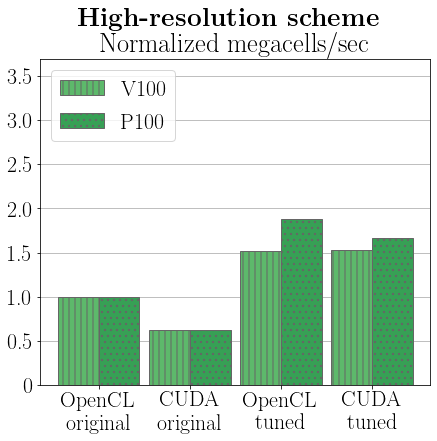

<Figure size 432x288 with 0 Axes>

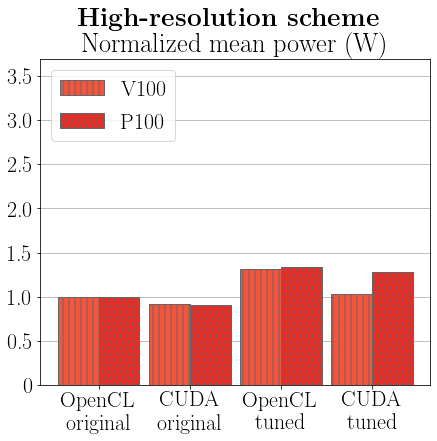

<Figure size 432x288 with 0 Axes>

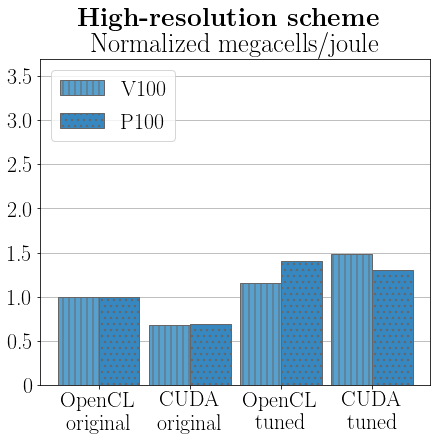

<Figure size 432x288 with 0 Axes>

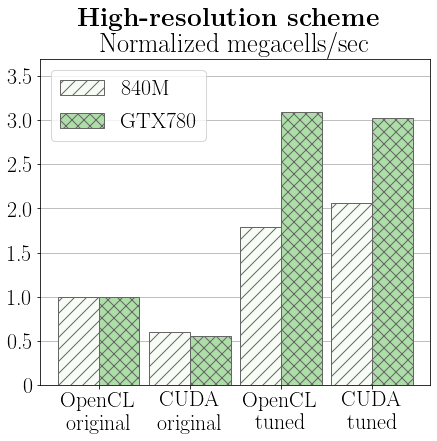

<Figure size 432x288 with 0 Axes>

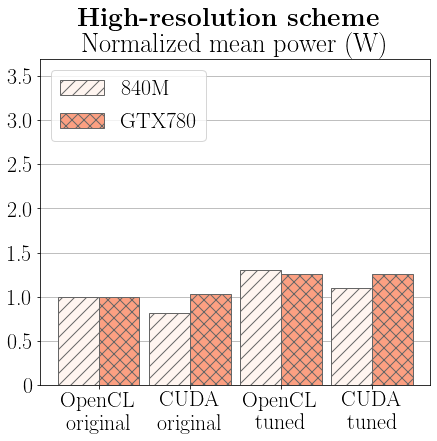

<Figure size 432x288 with 0 Axes>

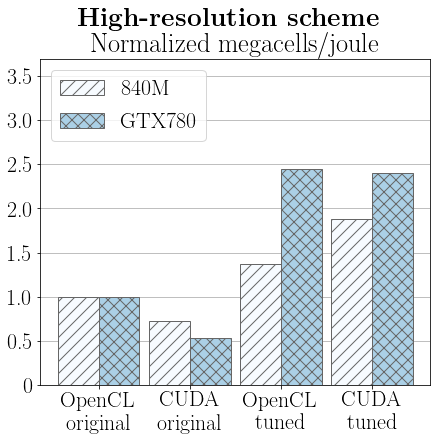

In [6]:
def plot_cuda_vs_opencl_results(opencl_files, cuda_files, key, title, filename=None, 
                                suptitle=None,
                                normalization=None, ignore_background=True, 
                                plot_indices=None, save_this=False, largefont=False):
    assert len(opencl_files) == len(cuda_files)
    
    opencl_df, _ = make_df(opencl_files, key, all_steps=False, ignore_background=ignore_background)
    cuda_df, _ = make_df(cuda_files, key, all_steps=False, ignore_background=ignore_background)
    
    fig = plt.figure()

    if largefont:
        fig, ax = plt.subplots(figsize=(7,6))
    else:
        fig, ax = plt.subplots(figsize=(12,6))

    num_bars = len(opencl_files)
    bar_width = 0.9 / num_bars
    bar_offset = 0.03
    if num_bars < 3:
        bar_offset = bar_width/4

    x = np.arange(4)
    architectures = list(zip(*opencl_files))[1]
    num_architectures = len(architectures)
    
    #print(opencl_df)
    #print(cuda_df)
    
    hatches = ['//', '\\\\', '++', 'xx', '--', '||', '..', '**']
    cmap = None
    cmap = plt.get_cmap("Greens")
    if key == mean_power_key:
        cmap = plt.get_cmap("Reds")
    elif key == megacells_per_joule_key:
        cmap = plt.get_cmap("Blues")
    elif key == mean_utilization_key:
        cmap = plt.get_cmap('Oranges')

    #if normalization is not None:
    #    cmap = plt.get_cmap('Blues')
    #else:
    #    cmap = plt.get_cmap("YlOrRd")
    colors = cmap(np.arange(7)/9)
    
    if plot_indices is None:
        plot_indices = np.arange(7)
 
    for i, label in enumerate(architectures):
        ocl_values = opencl_df[key + ' ' + label]
        cuda_values = cuda_df[key + ' ' + label]
        
        if normalization:
            n = 1 / ocl_values[0]
        elif (normalization == False) or (normalization is None):
            n = 1
        else:
            n = 1.0/normalization[i]
        
        ocl_values = ocl_values*n
        cuda_values = cuda_values*n
        
        values = [ocl_values[0], cuda_values[0], ocl_values[-1], cuda_values[-1]]
        #print(values)
        
        ax.bar(x+2*bar_offset + (i - num_architectures/2)*bar_width, values, bar_width, 
               label=label, hatch=hatches[plot_indices[i]], color=colors[plot_indices[i]],
               linewidth=1, edgecolor='0.4')

    labels = ["OpenCL \n original", "CUDA \n original", "OpenCL \n tuned", "CUDA \n tuned"]
    plt.xticks(x, labels)#, rotation='vertical')
    plt.grid(axis='y')
    
    if normalization:
        plt.ylim([0, 3.7])
        plt.yticks([0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5], [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5])
    
        
    plt.legend(loc='upper left')
    
    plt.title(title)
    if suptitle is not None:
        plt.suptitle(suptitle, y=1.0)
    
    if(filename):
        metadata = {
                    'original_files': json.dumps({"OpenCL": opencl_files, "CUDA": cuda_files}), 
                    'original_data': json.dumps({"OpenCL":opencl_df.to_csv(), "CUDA": cuda_df.to_csv()}), 
                    'created': time.strftime("%Y_%m_%d-%H_%M_%S"),
                    'hostname': socket.gethostname(),
                    'data_key': key
                    }
        if savefigs or save_this:
            plt.savefig(os.path.join(figfolder, filename), dpi=300,format='pdf',
                    transparent=True, pad_inches=0.0, frameon=None, 
                    metadata=metadata)
            print('Saved ' + str(filename))

            
plot_cuda_vs_opencl_results(smi(cdklm_opencl), smi(cdklm_cuda), megacells_key, 
                            "Normalized megacells/sec", 
                            "portability_smi_megacells_power_cdklm.pdf", 
                            suptitle=r'\textbf{High-resolution scheme}', largefont=True,
                            normalization=True, plot_indices=[5,6], save_this=True)
plot_cuda_vs_opencl_results(smi(cdklm_opencl), smi(cdklm_cuda), mean_power_key, 
                            "Normalized mean power (W)", 
                            "portability_smi_mean_power_cdklm.pdf", 
                            suptitle=r'\textbf{High-resolution scheme}', largefont=True,
                            normalization=True, plot_indices=[5,6], save_this=True)
plot_cuda_vs_opencl_results(smi(cdklm_opencl), smi(cdklm_cuda), megacells_per_joule_key, 
                            "Normalized megacells/joule", 
                            "portability_smi_megacells_per_joule_cdklm.pdf", 
                            suptitle=r'\textbf{High-resolution scheme}', largefont=True,
                            normalization=True, plot_indices=[5,6], save_this=True)

plot_cuda_vs_opencl_results(tool(cdklm_opencl), tool(cdklm_cuda), megacells_key, 
                            "Normalized megacells/sec", "portability_tool_megacells_power_cdklm.pdf", 
                            suptitle=r'\textbf{High-resolution scheme}', largefont=True,
                            normalization=True, plot_indices=[0,3], save_this=True)
plot_cuda_vs_opencl_results(tool(cdklm_opencl), tool(cdklm_cuda), mean_power_key, 
                            "Normalized mean power (W)", "portability_tool_mean_power_cdklm.pdf", 
                            suptitle=r'\textbf{High-resolution scheme}', largefont=True,
                            normalization=True, plot_indices=[0,3], save_this=True)
plot_cuda_vs_opencl_results(tool(cdklm_opencl), tool(cdklm_cuda), megacells_per_joule_key, 
                            "Normalized megacells/joule", "portability_tool_megacells_per_joule_cdklm.pdf", 
                            suptitle=r'\textbf{High-resolution scheme}', largefont=True,
                            normalization=True, plot_indices=[0,3], save_this=True)


/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/ipykernel_launcher.py:96: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/ipykernel_launcher.py:96: UserWarning: Unknown infodict keyword: original_files
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/ipykernel_launcher.py:96: UserWarning: Unknown infodict keyword: original_data
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/ipykernel_launcher.py:96: UserWarning: Unknown infodict keyword: created
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/ipykernel_launcher.py:96: UserWarning: Unknown infodict keyword: hostname
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/ipykernel_launcher.py:96: UserWarning: Unknown infodict keyword: data_key


Saved portability_smi_megacells_power_ctcs.pdf
Saved portability_smi_mean_power_ctcs.pdf
Saved portability_smi_megacells_per_joule_ctcs.pdf
Saved portability_tool_megacells_power_ctcs.pdf
Saved portability_tool_mean_power_ctcs.pdf
Saved portability_tool_megacells_per_joule_ctcs.pdf


<Figure size 432x288 with 0 Axes>

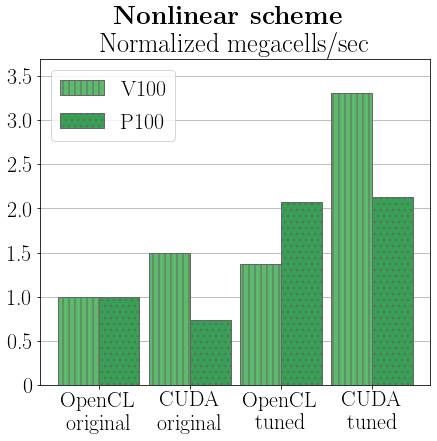

<Figure size 432x288 with 0 Axes>

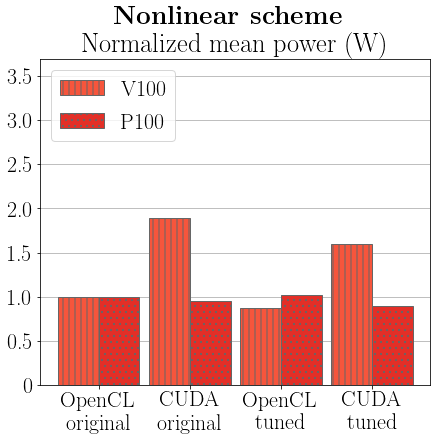

<Figure size 432x288 with 0 Axes>

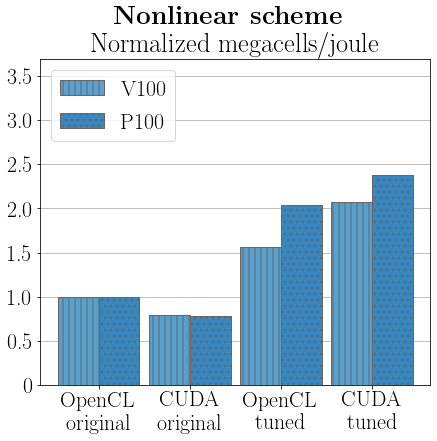

<Figure size 432x288 with 0 Axes>

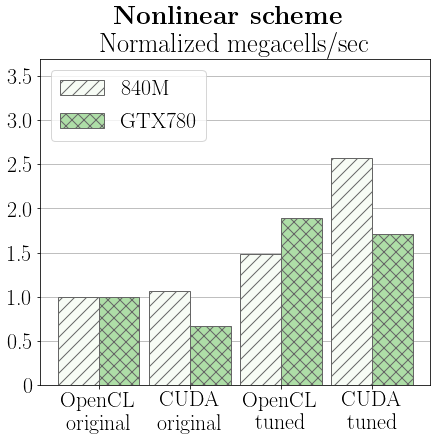

<Figure size 432x288 with 0 Axes>

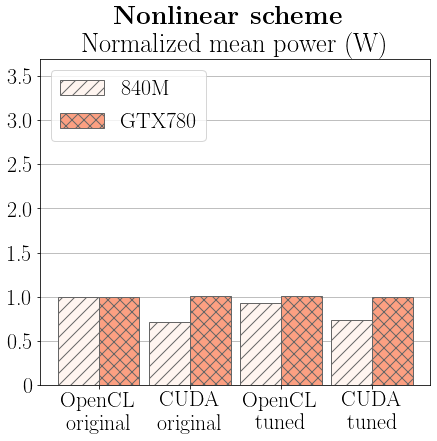

<Figure size 432x288 with 0 Axes>

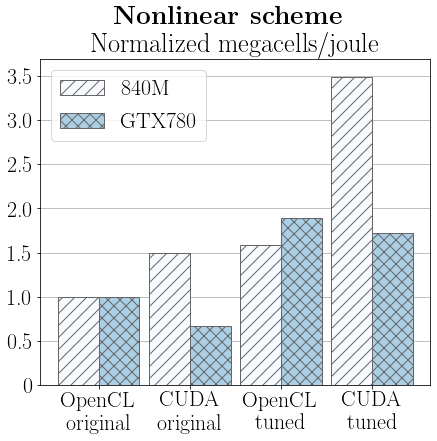

In [7]:

plot_cuda_vs_opencl_results(smi(ctcs_opencl), smi(ctcs_cuda), megacells_key, 
                            "Normalized megacells/sec", 
                            "portability_smi_megacells_power_ctcs.pdf", 
                            suptitle=r'\textbf{Nonlinear scheme}', largefont=True,
                            normalization=True, plot_indices=[5,6], save_this=True)
plot_cuda_vs_opencl_results(smi(ctcs_opencl), smi(ctcs_cuda), mean_power_key, 
                            "Normalized mean power (W)", 
                            "portability_smi_mean_power_ctcs.pdf", 
                            suptitle=r'\textbf{Nonlinear scheme}', largefont=True,
                            normalization=True, plot_indices=[5,6], save_this=True)
plot_cuda_vs_opencl_results(smi(ctcs_opencl), smi(ctcs_cuda), megacells_per_joule_key, 
                            "Normalized megacells/joule", 
                            "portability_smi_megacells_per_joule_ctcs.pdf", 
                            suptitle=r'\textbf{Nonlinear scheme}', largefont=True,
                            normalization=True, plot_indices=[5,6], save_this=True)

plot_cuda_vs_opencl_results(tool(ctcs_opencl), tool(ctcs_cuda), megacells_key, 
                            "Normalized megacells/sec", 
                            "portability_tool_megacells_power_ctcs.pdf", 
                            suptitle=r'\textbf{Nonlinear scheme}', largefont=True,
                            normalization=True, plot_indices=[0,3], save_this=True)
plot_cuda_vs_opencl_results(tool(ctcs_opencl), tool(ctcs_cuda), mean_power_key, 
                            "Normalized mean power (W)", 
                            "portability_tool_mean_power_ctcs.pdf", 
                            suptitle=r'\textbf{Nonlinear scheme}', largefont=True,
                            normalization=True, plot_indices=[0,3], save_this=True)
plot_cuda_vs_opencl_results(tool(ctcs_opencl), tool(ctcs_cuda), megacells_per_joule_key, 
                            "Normalized megacells/joule", 
                            "portability_tool_megacells_per_joule_ctcs.pdf", 
                            suptitle=r'\textbf{Nonlinear scheme}', largefont=True,
                            normalization=True, plot_indices=[0,3], save_this=True)


/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/ipykernel_launcher.py:96: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/ipykernel_launcher.py:96: UserWarning: Unknown infodict keyword: original_files
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/ipykernel_launcher.py:96: UserWarning: Unknown infodict keyword: original_data
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/ipykernel_launcher.py:96: UserWarning: Unknown infodict keyword: created
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/ipykernel_launcher.py:96: UserWarning: Unknown infodict keyword: hostname
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/ipykernel_launcher.py:96: UserWarning: Unknown infodict keyword: data_key


Saved portability_smi_megacells_power_fbl.pdf
Saved portability_smi_mean_power_fbl.pdf
Saved portability_smi_megacells_per_joule_fbl.pdf
Saved portability_tool_megacells_power_fbl.pdf
Saved portability_tool_mean_power_fbl.pdf
Saved portability_tool_megacells_per_joule_fbl.pdf


<Figure size 432x288 with 0 Axes>

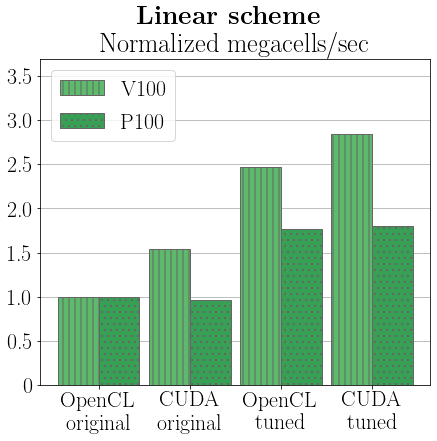

<Figure size 432x288 with 0 Axes>

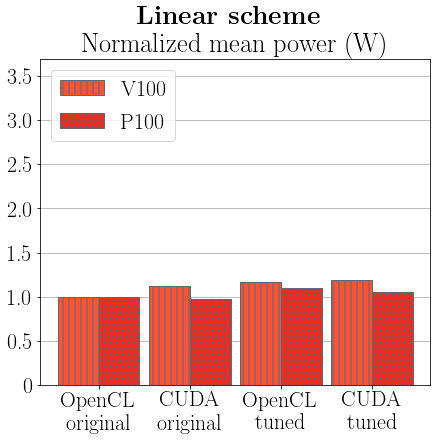

<Figure size 432x288 with 0 Axes>

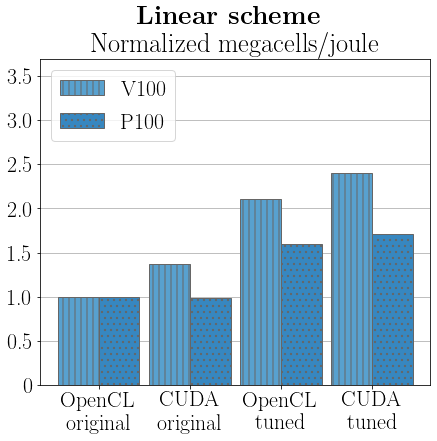

<Figure size 432x288 with 0 Axes>

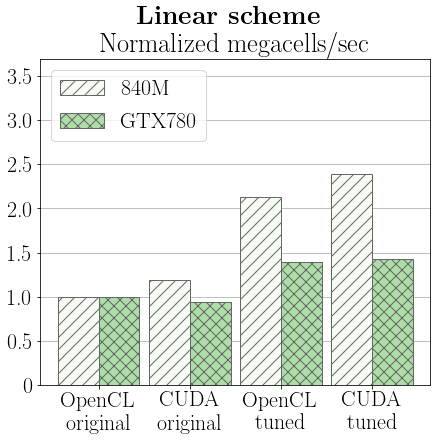

<Figure size 432x288 with 0 Axes>

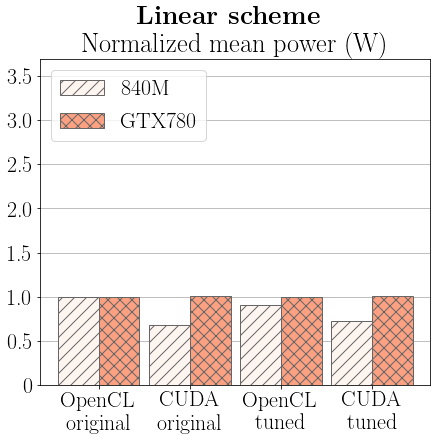

<Figure size 432x288 with 0 Axes>

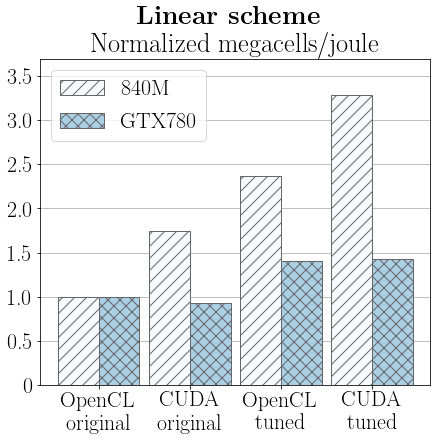

In [8]:

plot_cuda_vs_opencl_results(smi(fbl_opencl), smi(fbl_cuda), megacells_key, 
                            "Normalized megacells/sec", 
                            "portability_smi_megacells_power_fbl.pdf", 
                            suptitle=r'\textbf{Linear scheme}', largefont=True,
                            normalization=True, plot_indices=[5,6], save_this=True)
plot_cuda_vs_opencl_results(smi(fbl_opencl), smi(fbl_cuda), mean_power_key, 
                            "Normalized mean power (W)", 
                            "portability_smi_mean_power_fbl.pdf", 
                            suptitle=r'\textbf{Linear scheme}', largefont=True,
                            normalization=True, plot_indices=[5,6], save_this=True)
plot_cuda_vs_opencl_results(smi(fbl_opencl), smi(fbl_cuda), megacells_per_joule_key, 
                            "Normalized megacells/joule", 
                            "portability_smi_megacells_per_joule_fbl.pdf", 
                            suptitle=r'\textbf{Linear scheme}', largefont=True,
                            normalization=True, plot_indices=[5,6], save_this=True)

plot_cuda_vs_opencl_results(tool(fbl_opencl), tool(fbl_cuda), megacells_key, 
                            "Normalized megacells/sec", 
                            "portability_tool_megacells_power_fbl.pdf", 
                            suptitle=r'\textbf{Linear scheme}', largefont=True,
                            normalization=True, plot_indices=[0,3], save_this=True)
plot_cuda_vs_opencl_results(tool(fbl_opencl), tool(fbl_cuda), mean_power_key, 
                            "Normalized mean power (W)", 
                            "portability_tool_mean_power_fbl.pdf", 
                            suptitle=r'\textbf{Linear scheme}', largefont=True,
                            normalization=True, plot_indices=[0,3], save_this=True)
plot_cuda_vs_opencl_results(tool(fbl_opencl), tool(fbl_cuda), megacells_per_joule_key, 
                            "Normalized megacells/joule", 
                            "portability_tool_megacells_per_joule_fbl.pdf", 
                            suptitle=r'\textbf{Linear scheme}', largefont=True,
                            normalization=True, plot_indices=[0,3], save_this=True)


<Figure size 432x288 with 0 Axes>

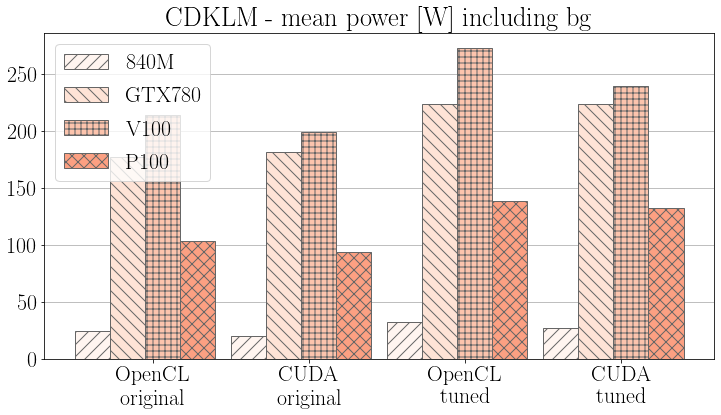

<Figure size 432x288 with 0 Axes>

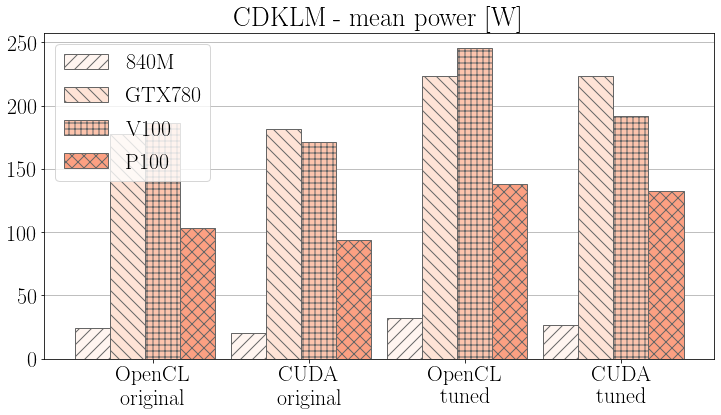

<Figure size 432x288 with 0 Axes>

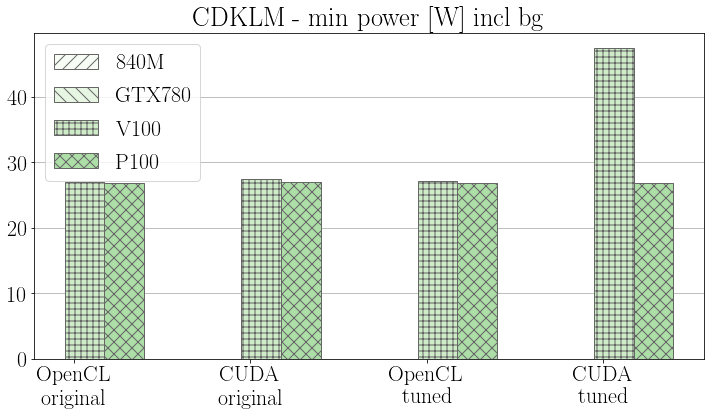

<Figure size 432x288 with 0 Axes>

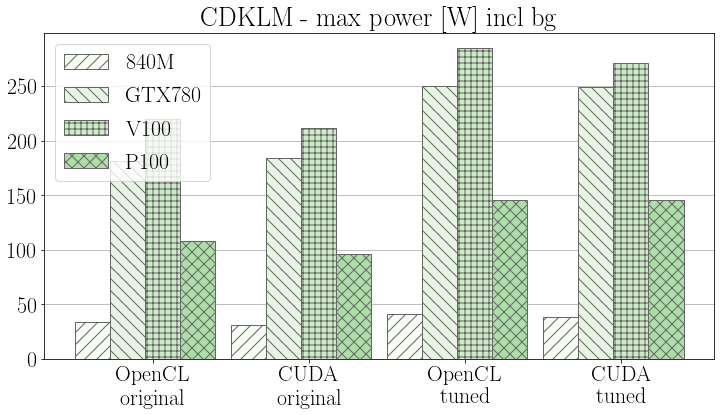

<Figure size 432x288 with 0 Axes>

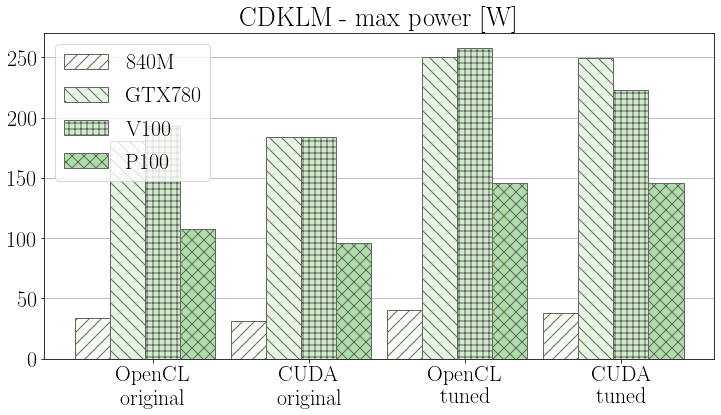

<Figure size 432x288 with 0 Axes>

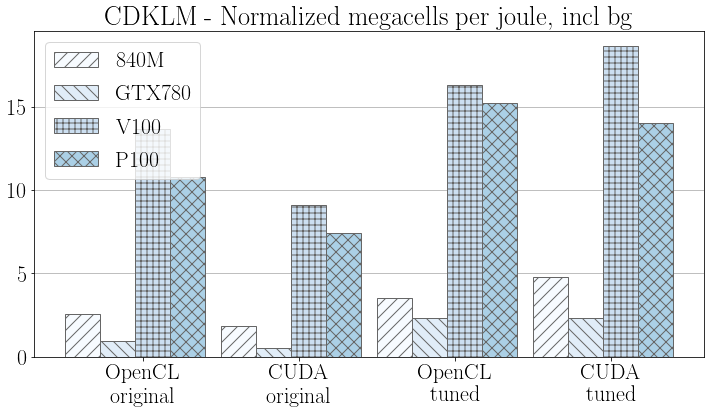

<Figure size 432x288 with 0 Axes>

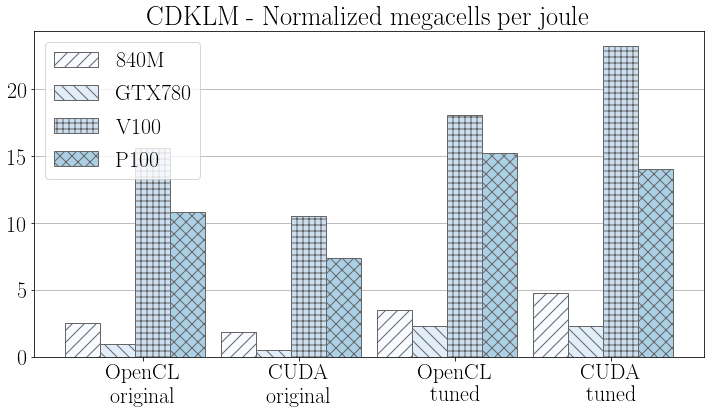

In [9]:

plot_cuda_vs_opencl_results(cdklm_opencl, cdklm_cuda, mean_power_key, "CDKLM - mean power [W] including bg", 
                            "mean_power_cdklm_incl_bg.pdf", normalization=False, ignore_background=False)
plot_cuda_vs_opencl_results(cdklm_opencl, cdklm_cuda, mean_power_key, "CDKLM - mean power [W]", "mean_power_cdklm_.pdf", 
                            normalization=False)
plot_cuda_vs_opencl_results(cdklm_opencl, cdklm_cuda, min_power_key, "CDKLM - min power [W] incl bg", 
                            "min_power_cdklm.pdf", normalization=False, ignore_background=False)
plot_cuda_vs_opencl_results(cdklm_opencl, cdklm_cuda, max_power_key, "CDKLM - max power [W] incl bg", 
                            "max_power_cdklm_incl_bg.pdf", normalization=False, ignore_background=False)
plot_cuda_vs_opencl_results(cdklm_opencl, cdklm_cuda, max_power_key, "CDKLM - max power [W]", "max_power_cdklm.pdf", 
                            normalization=False)

plot_cuda_vs_opencl_results(cdklm_opencl, cdklm_cuda, megacells_per_joule_key, "CDKLM - Normalized megacells per joule, incl bg",
                            "tuning_fbl.pdf", ignore_background=False)
plot_cuda_vs_opencl_results(cdklm_opencl, cdklm_cuda, megacells_per_joule_key, "CDKLM - Normalized megacells per joule", 
                            "tuning_fbl.pdf")


#plot_cuda_vs_opencl_results(ctcs_opencl, ctcs_cuda, mean_power_key, "CTCS - mean power [W]", "tuning_fbl.pdf", normalization=False)
#plot_cuda_vs_opencl_results(ctcs_opencl, ctcs_cuda, min_power_key, "CTCS - min power [W]", "tuning_fbl.pdf", normalization=False)
#plot_cuda_vs_opencl_results(ctcs_opencl, ctcs_cuda, max_power_key, "CTCS - max power [W]", "tuning_fbl.pdf", normalization=False)

#plot_cuda_vs_opencl_results(fbl_opencl, fbl_cuda, mean_power_key, "FBL - mean power [W]", "tuning_fbl.pdf", normalization=False)
#plot_cuda_vs_opencl_results(fbl_opencl, fbl_cuda, min_power_key, "FBL - min power [W]", "tuning_fbl.pdf", normalization=False)
#plot_cuda_vs_opencl_results(fbl_opencl, fbl_cuda, max_power_key, "FBL - max power [W]", "tuning_fbl.pdf", normalization=False)




/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


False

<Figure size 432x288 with 0 Axes>

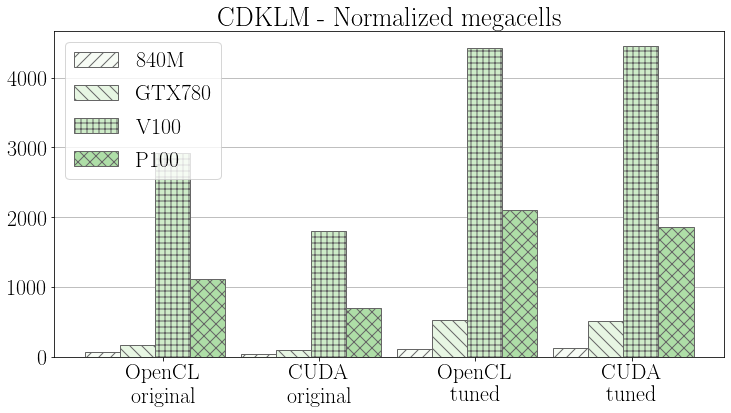

<Figure size 432x288 with 0 Axes>

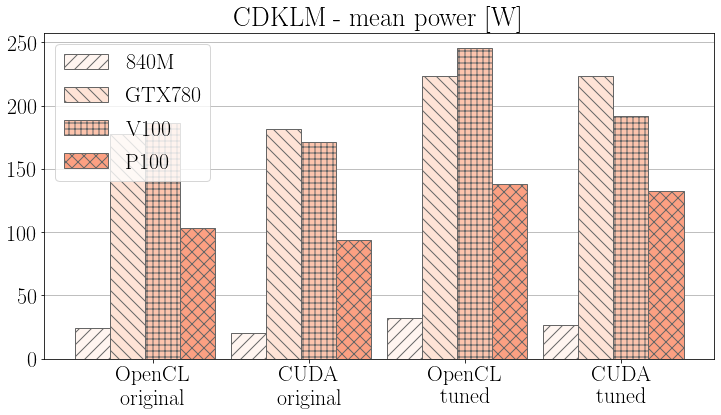

<Figure size 432x288 with 0 Axes>

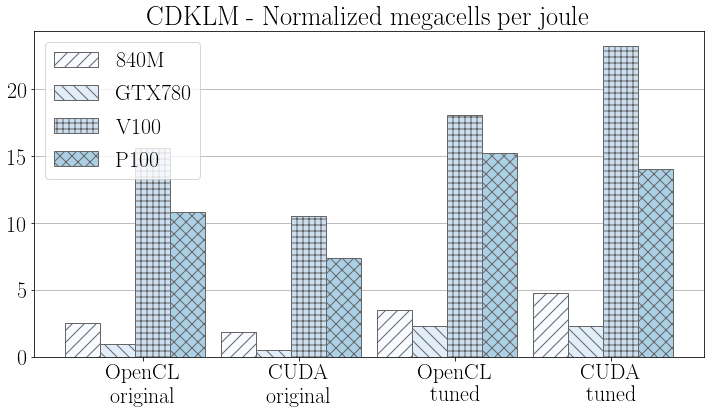

<Figure size 432x288 with 0 Axes>

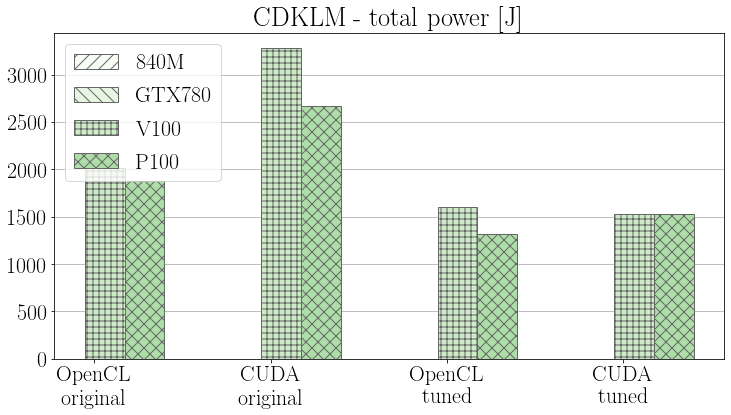

<Figure size 432x288 with 0 Axes>

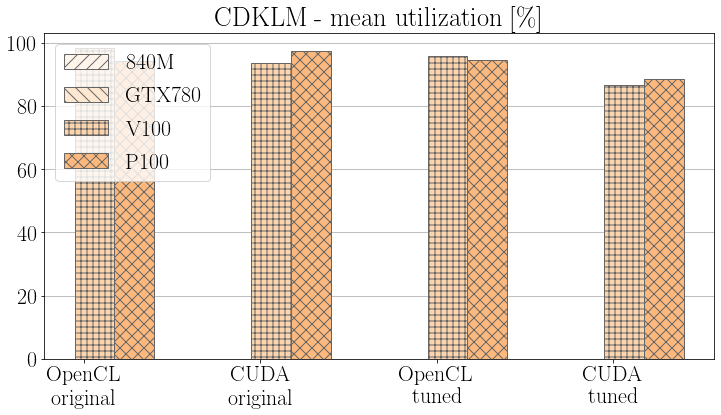

<Figure size 432x288 with 0 Axes>

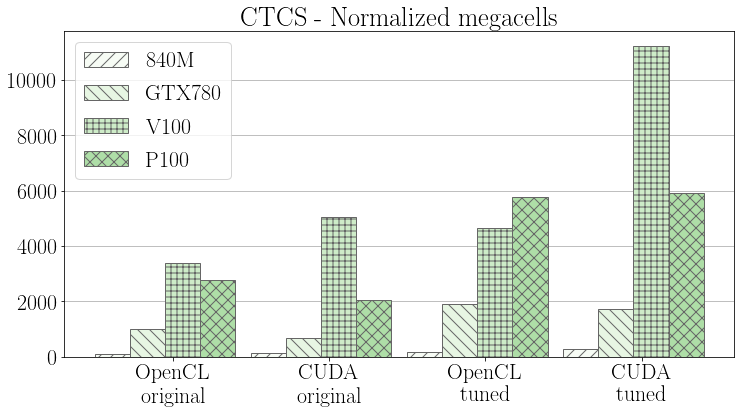

<Figure size 432x288 with 0 Axes>

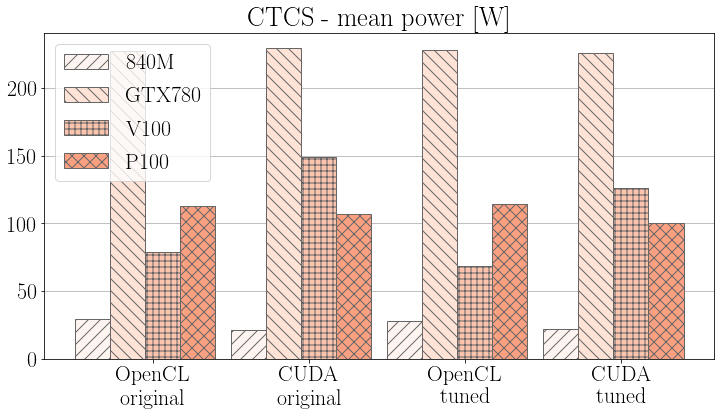

<Figure size 432x288 with 0 Axes>

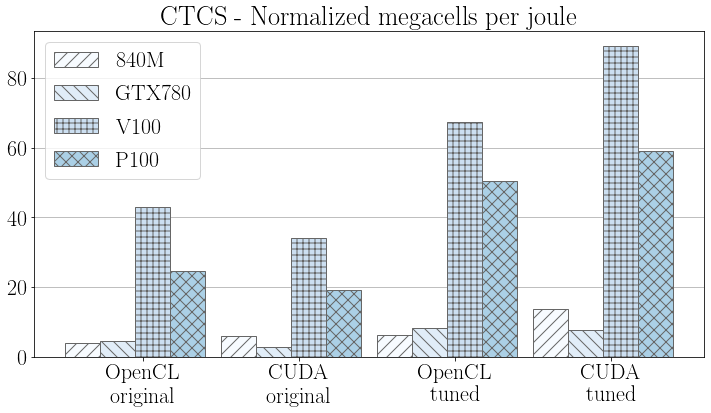

<Figure size 432x288 with 0 Axes>

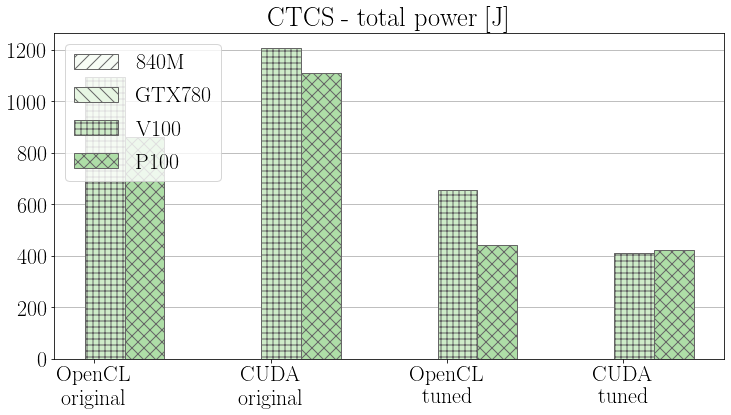

<Figure size 432x288 with 0 Axes>

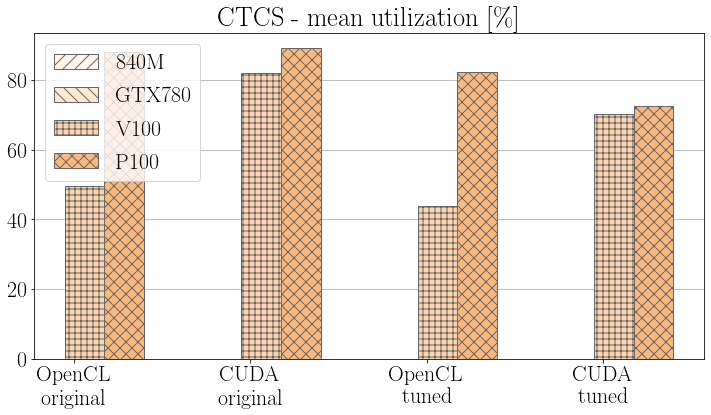

<Figure size 432x288 with 0 Axes>

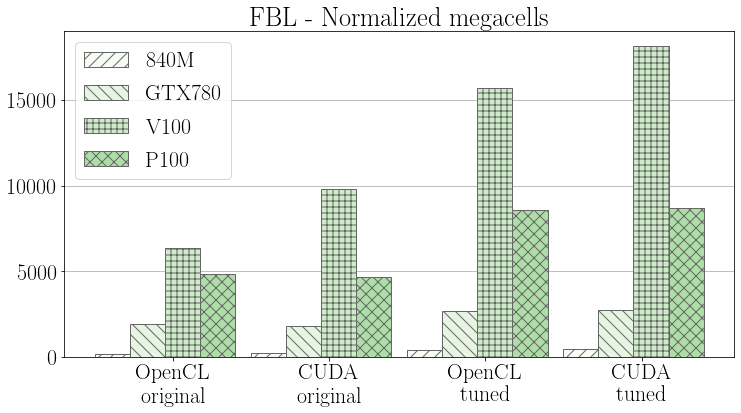

<Figure size 432x288 with 0 Axes>

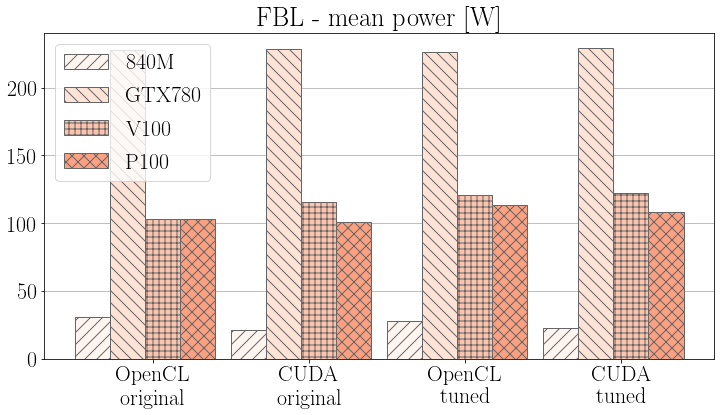

<Figure size 432x288 with 0 Axes>

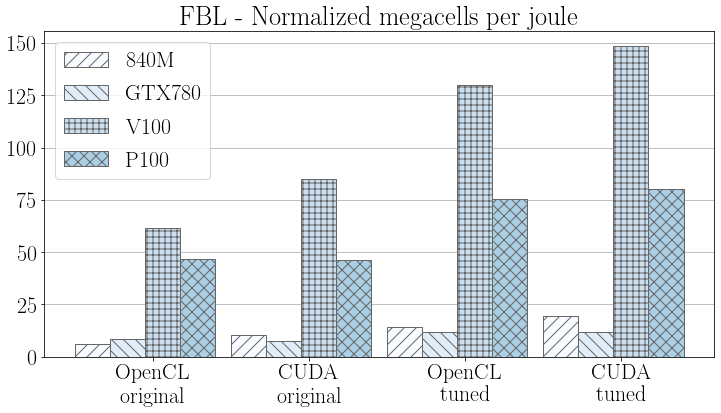

<Figure size 432x288 with 0 Axes>

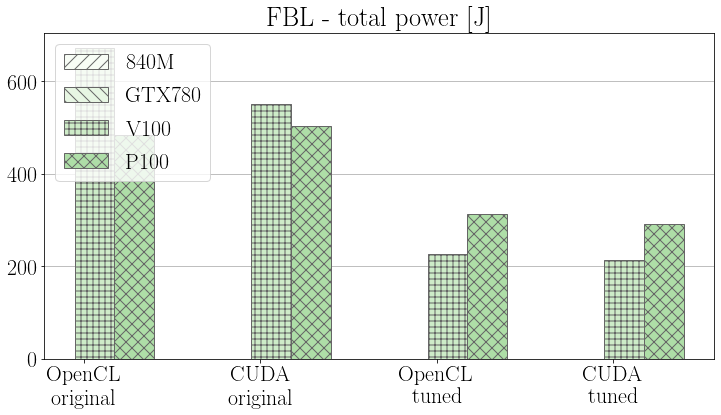

<Figure size 432x288 with 0 Axes>

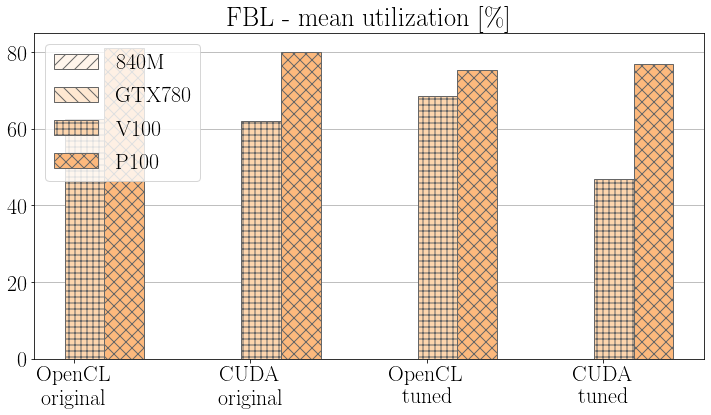

In [10]:

plot_cuda_vs_opencl_results(cdklm_opencl, cdklm_cuda, megacells_key, "CDKLM - Normalized megacells", "tuning_fbl.pdf")
plot_cuda_vs_opencl_results(cdklm_opencl, cdklm_cuda, mean_power_key, "CDKLM - mean power [W]", "tuning_fbl.pdf", normalization=False)
plot_cuda_vs_opencl_results(cdklm_opencl, cdklm_cuda, megacells_per_joule_key, "CDKLM - Normalized megacells per joule", "tuning_fbl.pdf")
plot_cuda_vs_opencl_results(cdklm_opencl, cdklm_cuda, total_power_key, "CDKLM - total power [J]", "tuning_fbl.pdf", normalization=False)
plot_cuda_vs_opencl_results(cdklm_opencl, cdklm_cuda, mean_utilization_key, "CDKLM - mean utilization [\%]", "tuning_fbl.pdf", normalization=False)

plot_cuda_vs_opencl_results(ctcs_opencl, ctcs_cuda, megacells_key, "CTCS - Normalized megacells", "tuning_fbl.pdf")
plot_cuda_vs_opencl_results(ctcs_opencl, ctcs_cuda, mean_power_key, "CTCS - mean power [W]", "tuning_fbl.pdf", normalization=False)
plot_cuda_vs_opencl_results(ctcs_opencl, ctcs_cuda, megacells_per_joule_key, "CTCS - Normalized megacells per joule", "tuning_fbl.pdf")
plot_cuda_vs_opencl_results(ctcs_opencl, ctcs_cuda, total_power_key, "CTCS - total power [J]", "tuning_fbl.pdf", normalization=False)
plot_cuda_vs_opencl_results(ctcs_opencl, ctcs_cuda, mean_utilization_key, "CTCS - mean utilization [\%]", "tuning_fbl.pdf", normalization=False)

#plot_cuda_vs_opencl_results(cdklm_opencl, cdklm_cuda, "CDKLM - Normalized megacells", "tuning_cdklm.pdf")
#plot_cuda_vs_opencl_results(ctcs_opencl, ctcs_cuda, "CTCS - Normalized megacells", "tuning_ctcs.pdf")
plot_cuda_vs_opencl_results(fbl_opencl, fbl_cuda, megacells_key, "FBL - Normalized megacells", "tuning_fbl.pdf")
plot_cuda_vs_opencl_results(fbl_opencl, fbl_cuda, mean_power_key, "FBL - mean power [W]", "tuning_fbl.pdf", normalization=False)
plot_cuda_vs_opencl_results(fbl_opencl, fbl_cuda, megacells_per_joule_key, "FBL - Normalized megacells per joule", "tuning_fbl.pdf")
plot_cuda_vs_opencl_results(fbl_opencl, fbl_cuda, total_power_key, "FBL - total power [J]", "tuning_fbl.pdf", normalization=False)
plot_cuda_vs_opencl_results(fbl_opencl, fbl_cuda, mean_utilization_key, "FBL - mean utilization [\%]", "tuning_fbl.pdf", normalization=False)


savefigs

## Plot results

In [11]:
def plot_results(files, title, key, columns=None, labels=None, filename=None, plot_indices=None, save_this=False):
    df, versions = make_df([files[2], files[3]], key)
    
    num_bars = len([files[2], files[3]])
    bar_width = 0.9 / num_bars
    bar_offset = 0.05
    if num_bars < 3:
        bar_offset = bar_width/4
    
    if (columns == None):
        columns = np.arange(len(versions))
        
    if (labels == None):
        labels = df['labels'][columns]
    
    assert (len(labels)== len(columns))
        
        
    label_rotation = 0
    fig_width = 12
    alignment = 'center'
    if len(labels) > 4:
        #label_rotation = 15
        #alignment = 'right'
        fig_width = fig_width*len(labels)/4.0
        
    fig = plt.figure()
    fig, ax = plt.subplots(figsize=(fig_width,6))

        
    x = np.arange(len(columns))
    architectures = list(zip(*[files[2], files[3]]))[1]
    num_architectures = len(architectures)
        
    hatches = ['//', '\\\\', '++', 'xx', '--', '||', '..', '**']
    cmap = plt.get_cmap("Greens")
    if key == mean_power_key:
        cmap = plt.get_cmap("Reds")
    elif key in [total_power_key, megacells_per_joule_key]:
        cmap = plt.get_cmap("Blues")
    elif key == mean_utilization_key:
        cmap = plt.get_cmap('Oranges')
    colors = cmap(np.arange(7)/9)
    
    if plot_indices is None:
        plot_indices = np.arange(7)
    
    for i, label in enumerate(architectures):
        values = df[key + ' ' + label]
        values = values / values[0] #Normalize
        values = values[columns]
        ax.bar(x+2*bar_offset + (i - num_architectures/2)*bar_width, values, bar_width,
               label=label, hatch=hatches[plot_indices[i]], color=colors[plot_indices[i]],
               linewidth=1, edgecolor='0.4')

    plt.xticks(x, labels, rotation=label_rotation, horizontalalignment=alignment) #rotation='vertical')
    #for label in axs[0].get_xmajorticklabels() + axs[1].get_xmajorticklabels():
    #    label.set_rotation(30)
    #    label.set_horizontalalignment("right")
    
    plt.grid(axis='y')
    plt.legend(loc='upper left')
    plt.ylim([0, 3])
    plt.yticks([0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0], [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0])
    
    plt.title(title)
    if(filename):
        metadata = {
                    'original_files': json.dumps(files), 
                    'original_data': json.dumps(df.to_csv()), 
                    'created': time.strftime("%Y_%m_%d-%H_%M_%S"),
                    'hostname': socket.gethostname(),
                    'data_key': key
                    }
        if savefigs or save_this:
            plt.savefig(os.path.join(figfolder, filename), dpi=300,format='pdf',
                    transparent=True, pad_inches=0.0, frameon=None, 
                    metadata=metadata)
            print('Saved '+str(filename))


/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/ipykernel_launcher.py:78: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Unknown infodict keyword: original_files
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Unknown infodict keyword: original_data
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Unknown infodict keyword: created
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Unknown infodict keyword: hostname
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Unknown infodict keyword: data_key
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-p

Saved cuda_cdklm_tuning_v100.pdf
Saved cuda_cdklm_tuning_mean_power_v100.pdf
Saved cuda_cdklm_tuning_total_power_v100.pdf
Saved cuda_cdklm_tuning_megacells_per_joule_v100.pdf
Saved cuda_cdklm_tuning_mean_utilization_v100.pdf


<Figure size 432x288 with 0 Axes>

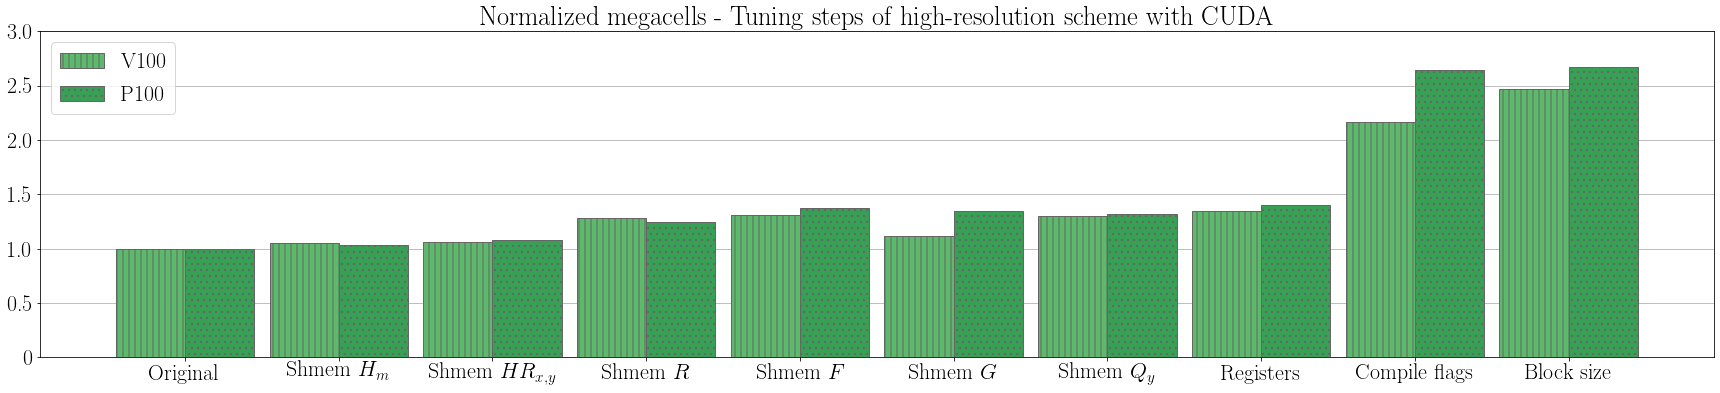

<Figure size 432x288 with 0 Axes>

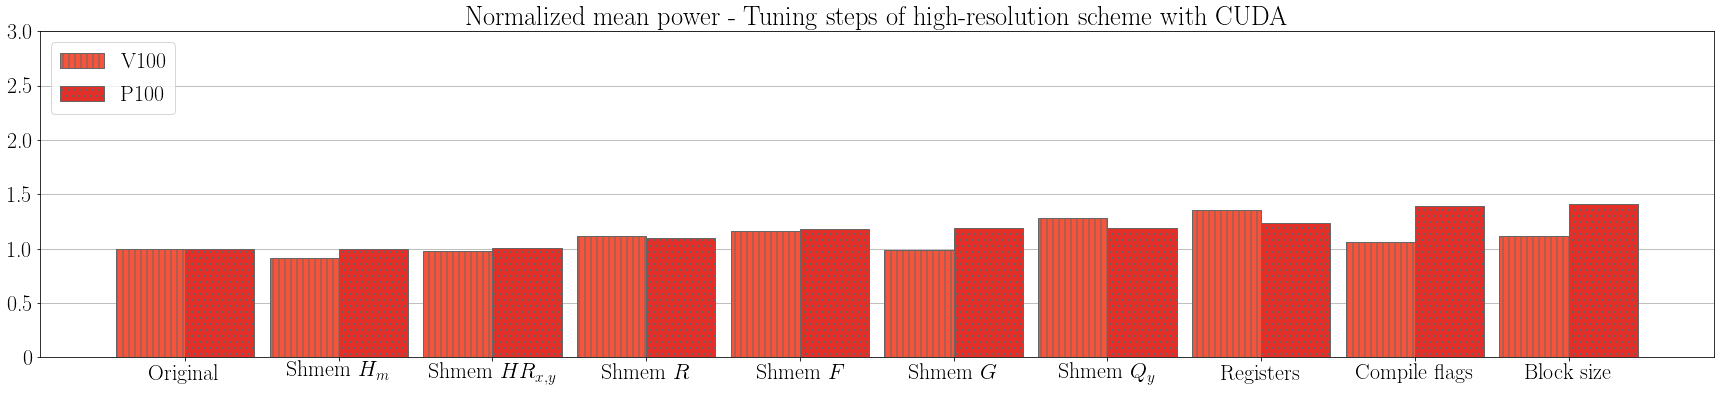

<Figure size 432x288 with 0 Axes>

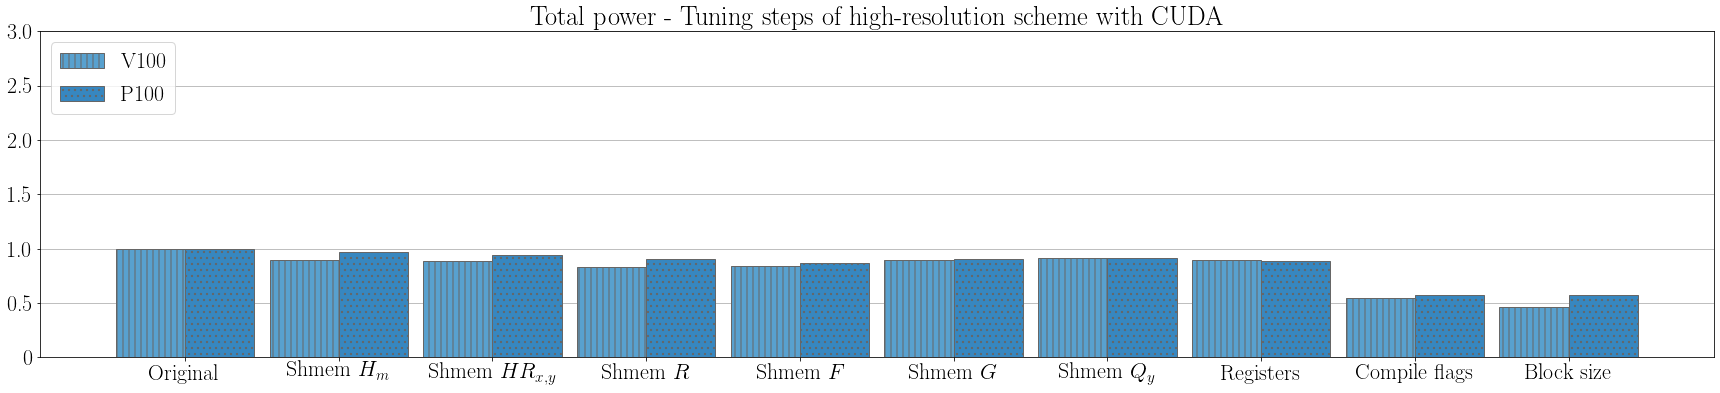

<Figure size 432x288 with 0 Axes>

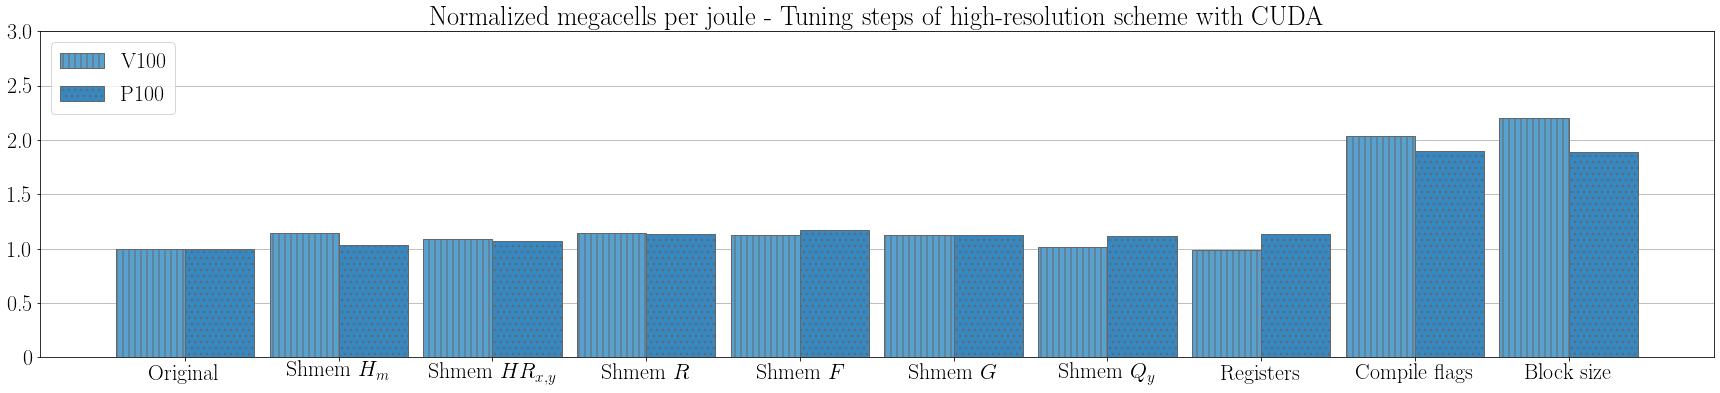

<Figure size 432x288 with 0 Axes>

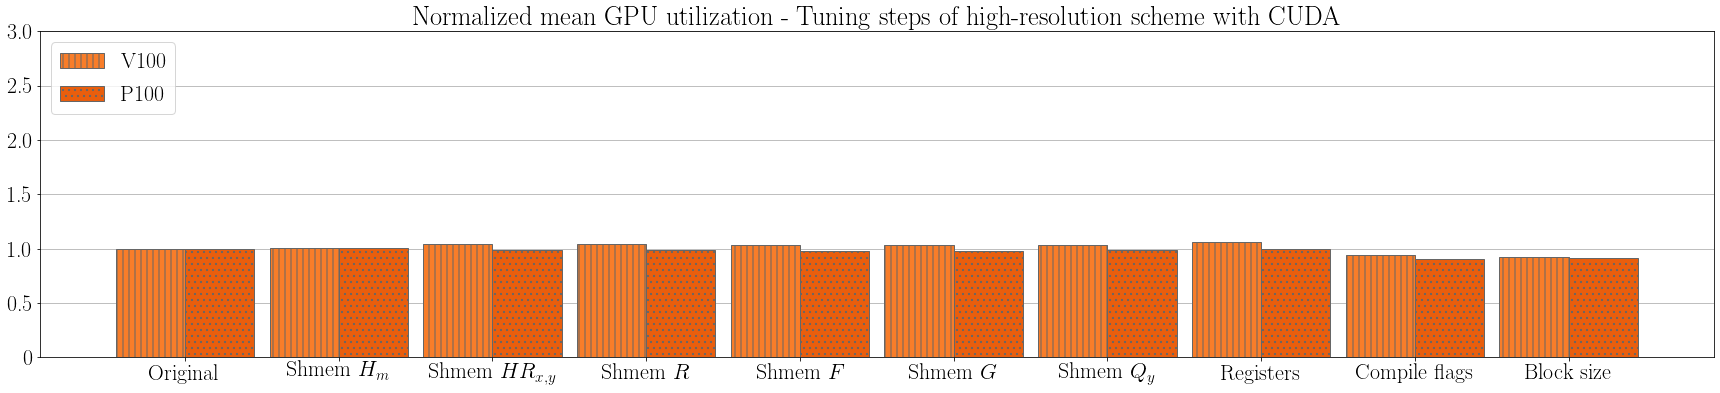

<Figure size 432x288 with 0 Axes>

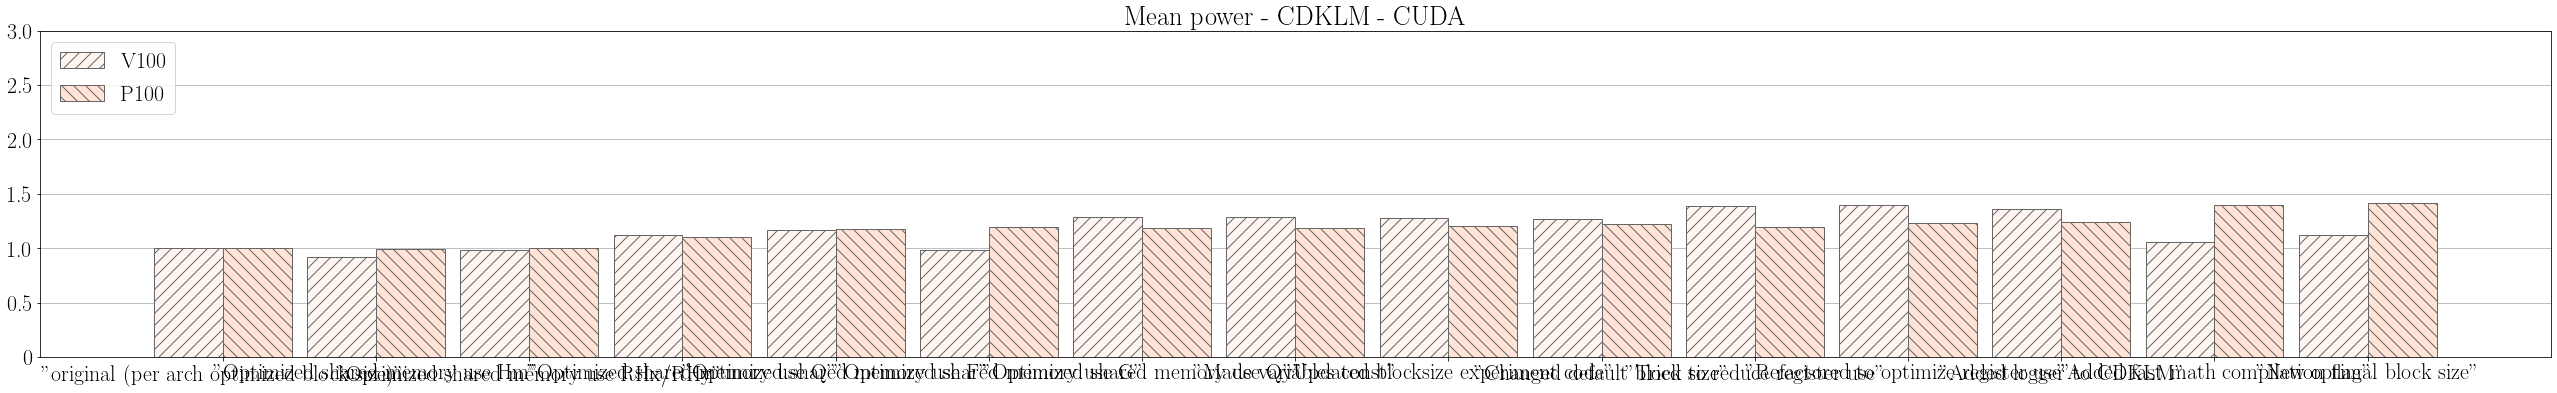

<Figure size 432x288 with 0 Axes>

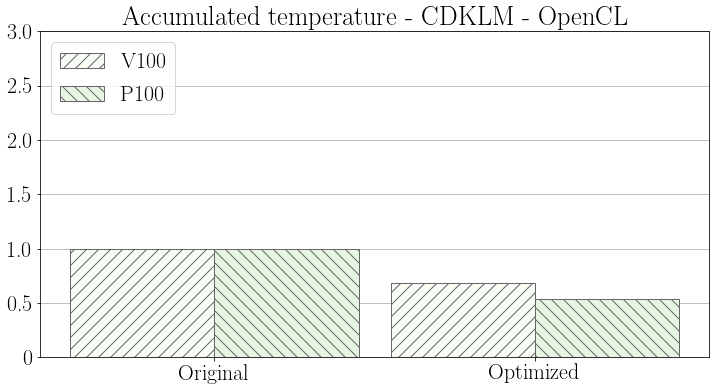

In [12]:
#plot_results(cdklm_cuda, "Mean power CDKLM - CUDA", key=mean_power_key, 
#             columns=[0, 6, 13, 14], 
#             labels=["Original", "Shared memory", "Compilation flags", "Block size"], 
#             filename="cuda_cdklm.pdf")

shmem = "Shmem "
plot_results(cdklm_cuda, "Normalized megacells - Tuning steps of high-resolution scheme with CUDA", 
             key=megacells_key,
             columns=[0,1,2,3,4,5,6, 12, 13, 14],
             labels=["Original", 
                     shmem + "$H_m$",
                     shmem + "$HR_{x,y}$",
                     shmem + "$R$",
                     shmem + "$F$",
                     shmem + "$G$",
                     shmem + "$Q_y$",
                     "Registers",
                     "Compile flags", 
                     "Block size"], 
             filename="cuda_cdklm_tuning_v100.pdf", plot_indices=[5,6], save_this=True)

plot_results(cdklm_cuda, "Normalized mean power - Tuning steps of high-resolution scheme with CUDA", 
             key=mean_power_key,
             columns=[0,1,2,3,4,5,6, 12, 13, 14],
             labels=["Original", 
                     shmem + "$H_m$",
                     shmem + "$HR_{x,y}$",
                     shmem + "$R$",
                     shmem + "$F$",
                     shmem + "$G$",
                     shmem + "$Q_y$",
                     "Registers",
                     "Compile flags", 
                     "Block size"], 
             filename="cuda_cdklm_tuning_mean_power_v100.pdf", plot_indices=[5,6], save_this=True)


plot_results(cdklm_cuda, "Total power - Tuning steps of high-resolution scheme with CUDA", 
             key=total_power_key,
             columns=[0,1,2,3,4,5,6, 12, 13, 14],
             labels=["Original", 
                     shmem + "$H_m$",
                     shmem + "$HR_{x,y}$",
                     shmem + "$R$",
                     shmem + "$F$",
                     shmem + "$G$",
                     shmem + "$Q_y$",
                     "Registers",
                     "Compile flags", 
                     "Block size"], 
             filename="cuda_cdklm_tuning_total_power_v100.pdf", plot_indices=[5,6], save_this=True)

plot_results(cdklm_cuda, "Normalized megacells per joule - Tuning steps of high-resolution scheme with CUDA", 
             key=megacells_per_joule_key,
             columns=[0,1,2,3,4,5,6, 12, 13, 14],
             labels=["Original", 
                     shmem + "$H_m$",
                     shmem + "$HR_{x,y}$",
                     shmem + "$R$",
                     shmem + "$F$",
                     shmem + "$G$",
                     shmem + "$Q_y$",
                     "Registers",
                     "Compile flags", 
                     "Block size"], 
             filename="cuda_cdklm_tuning_megacells_per_joule_v100.pdf", plot_indices=[5,6], save_this=True)

plot_results(cdklm_cuda, "Normalized mean GPU utilization - Tuning steps of high-resolution scheme with CUDA", 
             key=mean_utilization_key,
             columns=[0,1,2,3,4,5,6, 12, 13, 14],
             labels=["Original", 
                     shmem + "$H_m$",
                     shmem + "$HR_{x,y}$",
                     shmem + "$R$",
                     shmem + "$F$",
                     shmem + "$G$",
                     shmem + "$Q_y$",
                     "Registers",
                     "Compile flags", 
                     "Block size"], 
             filename="cuda_cdklm_tuning_mean_utilization_v100.pdf", plot_indices=[5,6], save_this=True)

plot_results(cdklm_cuda, "Mean power - CDKLM - CUDA", 
             key=mean_power_key,
             columns=None, labels=None, 
             filename="cuda_cdklm_all.pdf")

plot_results(cdklm_opencl, "Accumulated temperature - CDKLM - OpenCL", 
             key=cumsum_temperature_key, 
             labels=["Original", "Optimized"], 
             filename="opencl_cdklm.pdf")

<Figure size 432x288 with 0 Axes>

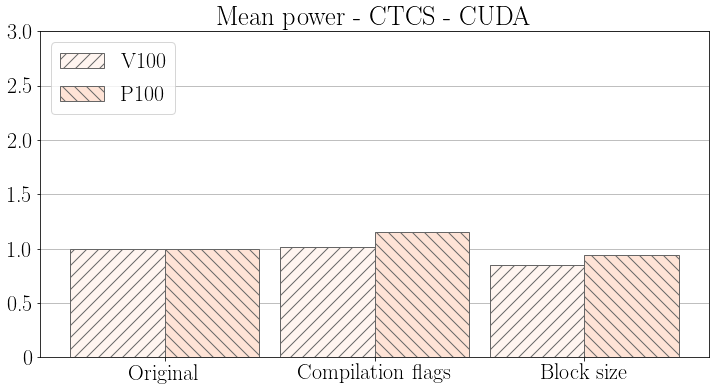

<Figure size 432x288 with 0 Axes>

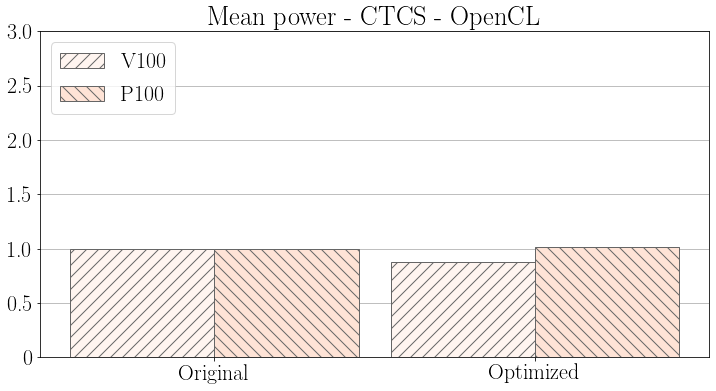

In [13]:
plot_results(ctcs_cuda, "Mean power - CTCS - CUDA", 
             key=mean_power_key,
             columns=[0, 7, 8], labels=["Original", "Compilation flags", "Block size"], filename="cuda_ctcs.pdf")


plot_results(ctcs_opencl, "Mean power - CTCS - OpenCL", 
             key=mean_power_key,
             labels=["Original", "Optimized"], filename="opencl_ctcs.pdf")

<Figure size 432x288 with 0 Axes>

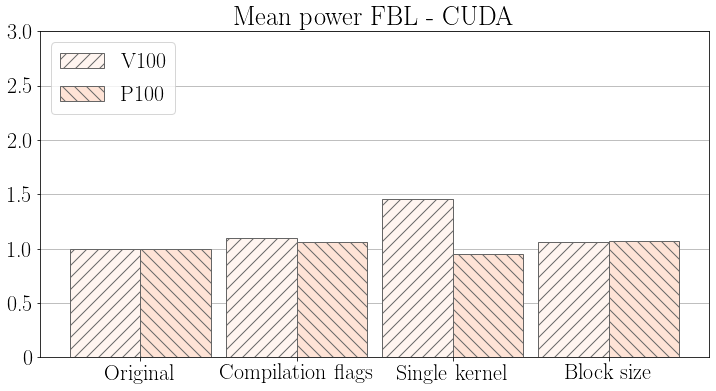

<Figure size 432x288 with 0 Axes>

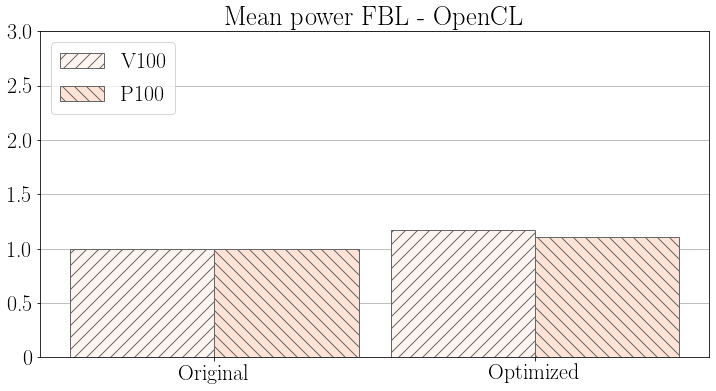

In [14]:
plot_results(fbl_cuda, "Mean power FBL - CUDA", 
             key=mean_power_key,
             labels=["Original", "Compilation flags", "Single kernel", "Block size"], filename="cuda_fbl.pdf")


plot_results(fbl_opencl, "Mean power FBL - OpenCL", 
             key=mean_power_key,
             labels=["Original", "Optimized"], filename="opencl_fbl.pdf")

In [15]:
np.__version__


'1.17.0'

# Plotting the development of energy use

Original CUDA mean power 198.6701201201201 V100 162.67988962472407
Tuned CUDA mean power 290.46169067475364 V100 273.14672689367615
Original OpenCL mean power 242.70308510638299 V100 181.35996753246752
Tuned OpenCL mean power 285.47877049180335 V100 189.37194214876033
Original CUDA mean power nan V100 41.51526315789474
Tuned CUDA mean power 173.32622641509437 V100 107.06843930635839
Original OpenCL mean power 160.62359038598512 V100 160.52368702318674
Tuned OpenCL mean power 120.4321641791045 V100 96.30507874015747
Original CUDA mean power 174.284 V100 115.89699999999998
Tuned CUDA mean power 278.1978593272171 V100 227.60894854586127
Original OpenCL mean power 164.5162637362637 V100 112.8479146919431
Tuned OpenCL mean power 173.72562499999998 V100 89.97526315789473
Original CUDA mean power 93.76803163444639 P100 83.54493468795356
Tuned CUDA mean power 132.37389610389613 P100 98.91267806267808
Original OpenCL mean power 103.24344352617081 P100 86.35221532091096
Tuned OpenCL mean power 1

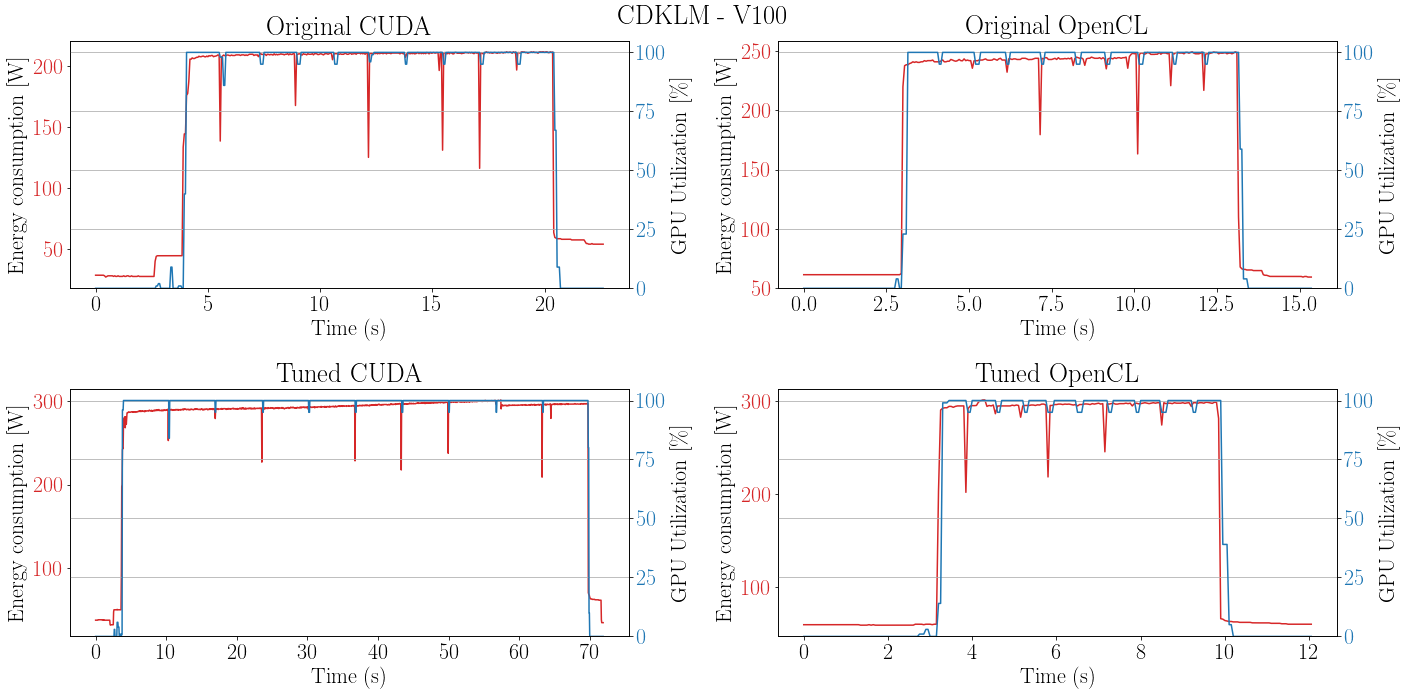

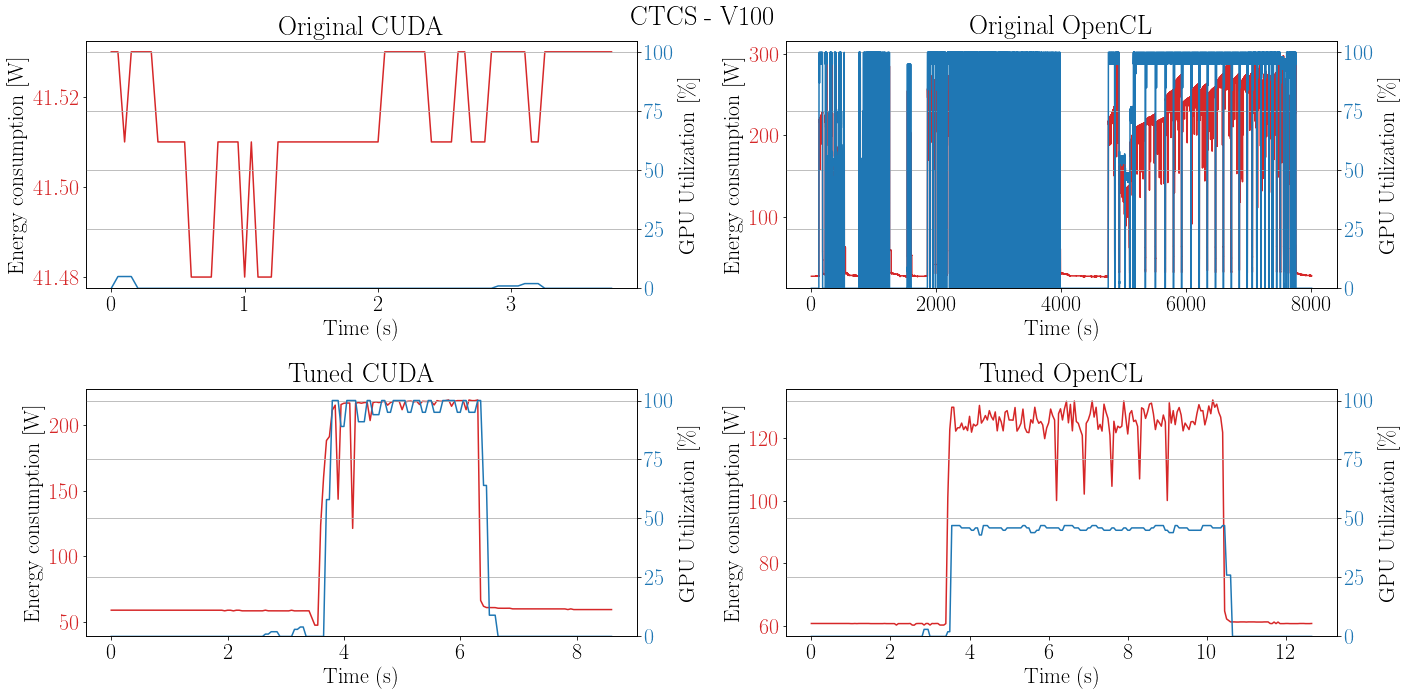

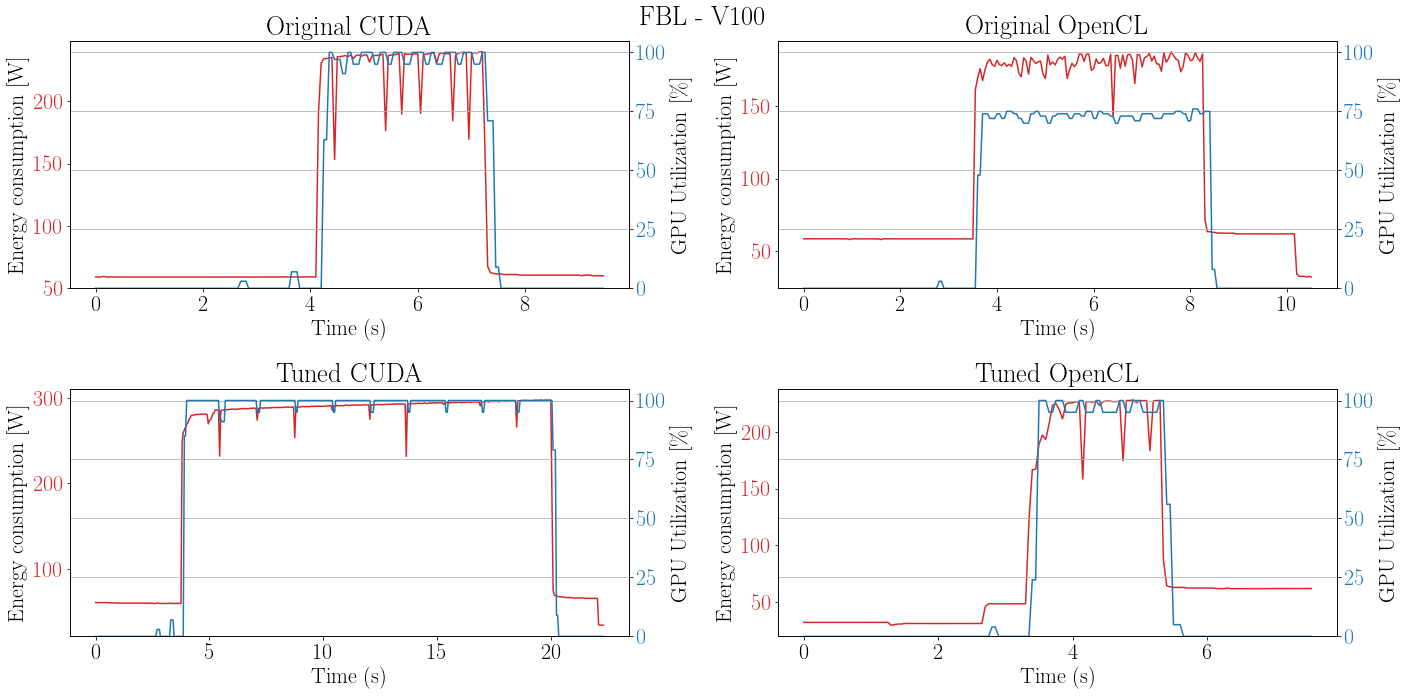

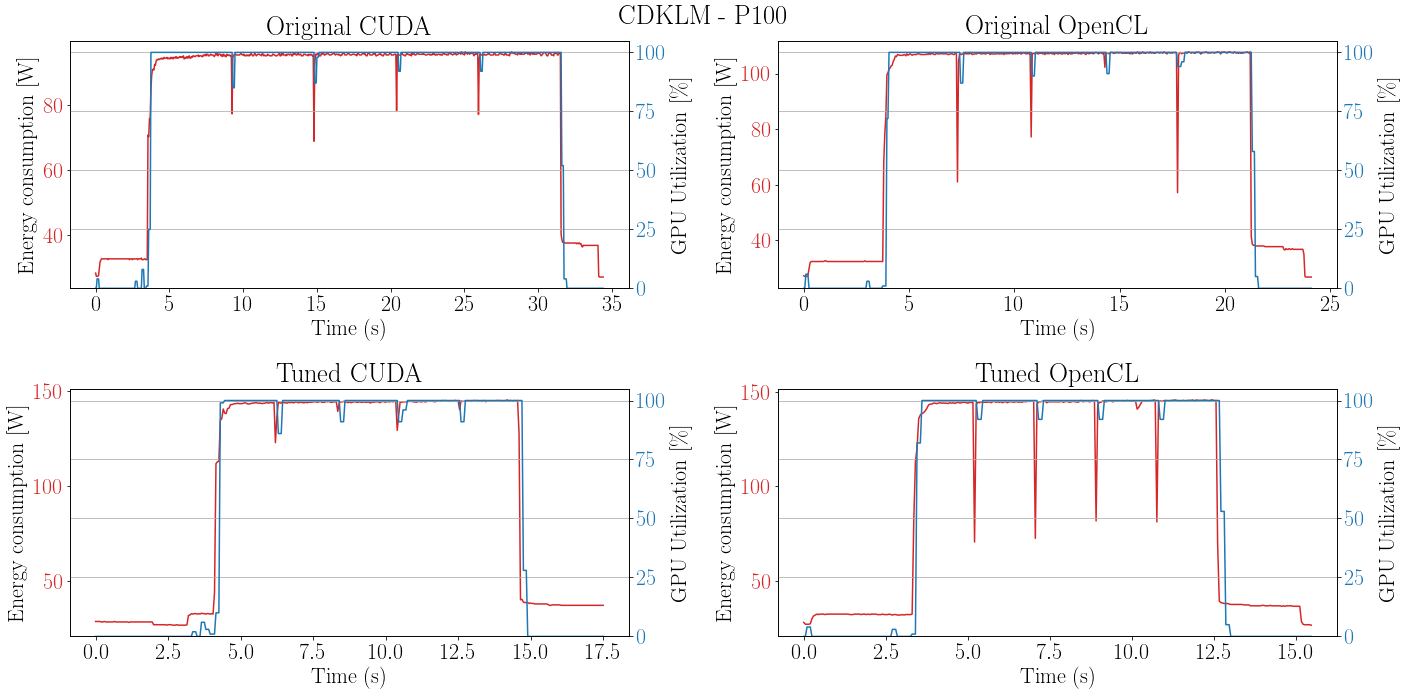

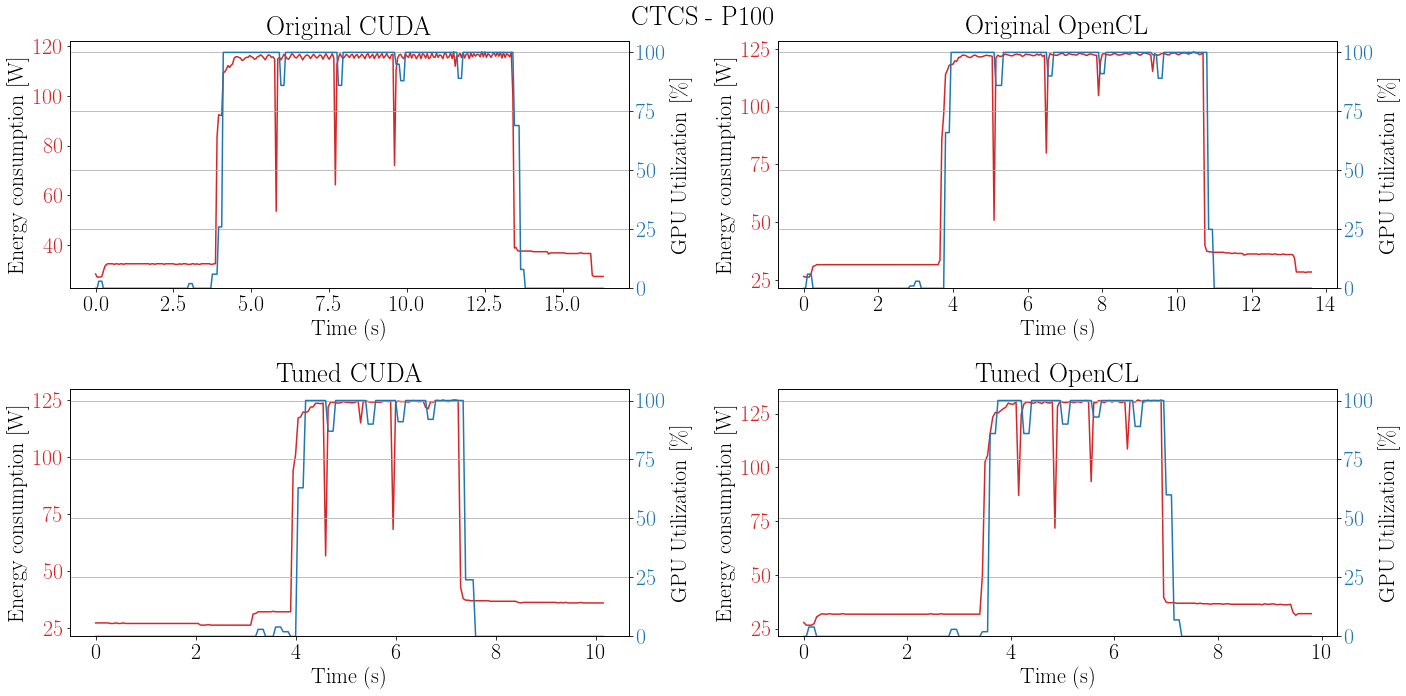

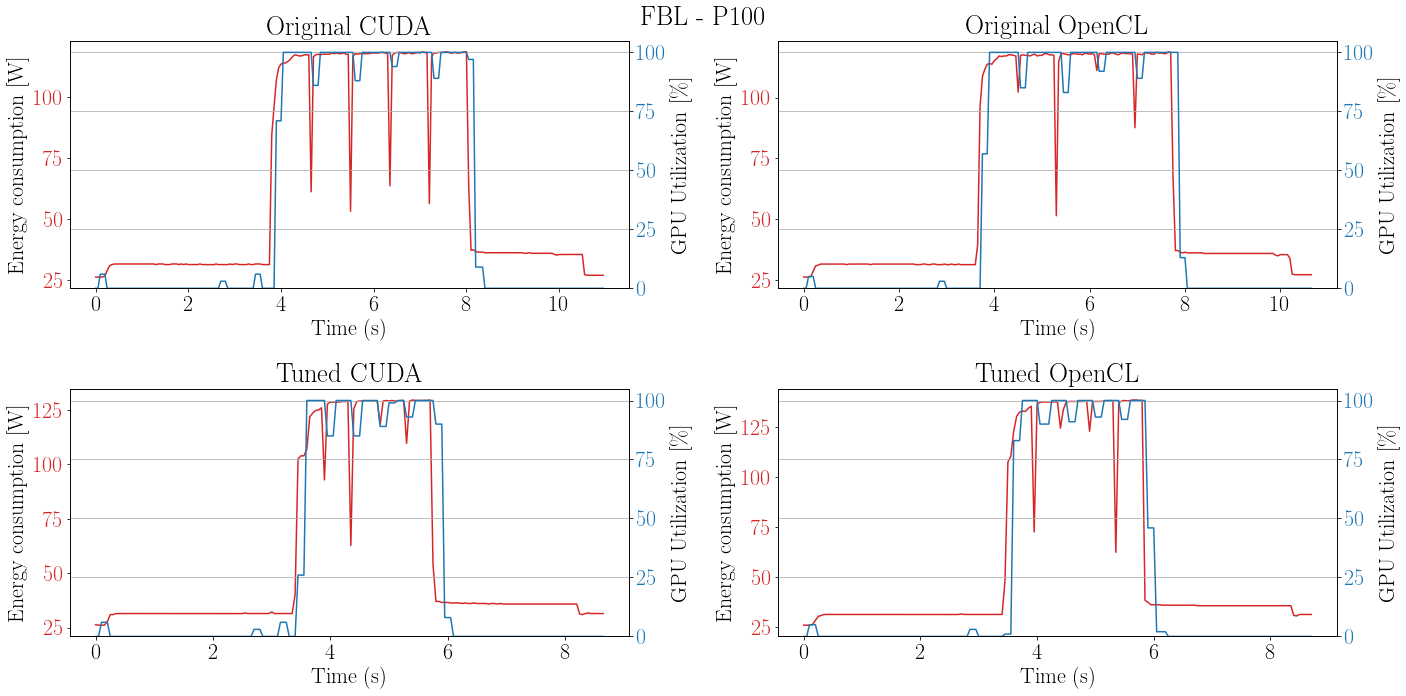

In [16]:

### Signature of the save command for the input files:
# np.savez(outfile, versions=df['git_commit'], 
#          labels=df['label'], 
#          megacells=megacells,
#          max_temperature=max_temperature,
#          min_temperature=min_temperature,
#          cumsum_temperature=cumsum_temperature,
#          max_power=max_power,
#          min_power=min_power,
#          total_power=total_power,
#          mean_power=mean_power,
#          max_utilization=max_utilization,
#          min_utilization=min_utilization,
#          mean_utilization=mean_utilization,
#          nvidia_smi_files=nvidia_smi_files,
#          args=json.dumps(vars(args)), timestamp=current_time)

temp_key  = 'temperature.gpu'
power_key = 'power.draw [W]'
utilization_key = 'utilization.gpu [%]'
fan_key = 'fan.speed [%]'
    
smi_loop_ms = 50
smi_entries_per_sec = round(1000/smi_loop_ms) # Number of smi log entries per second
sleep_duration_sec = 3
num_entries_to_ignore = smi_entries_per_sec*sleep_duration_sec 


def recover_smi_filename_from_github_hash(folder, git):
    best_filename = None
    for filename in os.listdir(folder):
        if git in filename:
            #print(filename + '  <----')
            
            if best_filename is None:
                best_filename = filename
                continue
            
            for i in range(len(filename)):
                
                if filename[i] > best_filename[i]:
                    best_filename = filename
                    #print('^---- new best!')
                    continue
                elif filename[i] < best_filename[i]:
                    continue
            
    assert(best_filename is not None), 'found no smi-report file...'
    return os.path.join(folder, best_filename)

# Helper function for reading values from the nvidia-smi file
def read_smi_file(smi_log_file, drop_inactive=True ):
    #print('Reading file: ', smi_log_file)
    smi_log = pd.read_csv(smi_log_file)
    
    
    # Remove whitespaces from column names:
    smi_log.rename(columns=lambda x: x.strip(), inplace=True)

    #for col in smi_log.columns:
    #    print(col)
        
    # Parse missing values
    smi_log = smi_log.replace(' [Not Supported]', np.NaN)
    
    # Helper function for parcing percent values
    def parse_value(df, key, unit):
        if not pd.isnull(df[key].iloc[0]):
            #print('fixing ' + key)
            df[key] = df[key].str.replace(' ','')
            df[key] = df[key].str.replace(unit, '')
            df[key] = pd.to_numeric(smi_log[key])
            
    parse_value(smi_log, utilization_key, '%')
    parse_value(smi_log, fan_key, '%')
    parse_value(smi_log, power_key, 'W')
    
    # Find min and max 
    max_temperature = smi_log[temp_key].max()
    min_temperature = smi_log[temp_key].min()
    min_power_draw  = smi_log[power_key].min()
    max_power_draw  = smi_log[power_key].max()
    min_utilization = smi_log[utilization_key].min()
    max_utilization = smi_log[utilization_key].max()
    
    # temperature*seconds
    all_sum_temperature = smi_log[temp_key].sum()*smi_loop_ms/1000

    # Drop first and last columns according to sleep time and log frequency
    # This compensates for the sleep commands above.
    if drop_inactive:
        smi_log.drop(smi_log.head(num_entries_to_ignore).index,inplace=True)
        smi_log.drop(smi_log.tail(num_entries_to_ignore).index,inplace=True)
    
    cumsum_temperature = smi_log[temp_key].sum()*smi_loop_ms/1000
    
    total_power = smi_log[power_key].sum()*smi_loop_ms/1000
    if np.isnan(max_power_draw) and np.isnan(min_power_draw):
        total_power = np.NaN
    mean_power = smi_log[power_key].mean()
    mean_utilization = smi_log[utilization_key].mean()
        
    smi_values = {max_temperature_key: max_temperature,
                  min_temperature_key: min_temperature,
                  cumsum_temperature_key: cumsum_temperature,
                  max_power_key: max_power_draw,
                  min_power_key: min_power_draw,
                  total_power_key: total_power,
                  mean_power_key: mean_power,
                  max_utilization_key: max_utilization,
                  min_utilization_key: min_utilization,
                  mean_utilization_key: mean_utilization
                 }

    return smi_values, smi_log




def plot_development(files, optimization_step, title, drop_inactive=True, ax1=None): 
    #, key, columns=None, labels=None, filename=None):
    #print(files)
    assert(len(files) == 3), 'files should be a single result, not results across different GPUs.'
        
    num_optimization_steps = None
    smi_filename = None
        
    with np.load(files[0], allow_pickle=True) as data:
        num_optimization_steps = len(data['versions'])
        if optimization_step < 0:
            optimization_step = num_optimization_steps + optimization_step
        
        #print('optimization_step: ', optimization_step)
        
        git_version = data['versions'][optimization_step]
        #print('git_version: ', git_version)
        
        smi_filename = recover_smi_filename_from_github_hash(files[2], git_version)
      
    
    #print('smi_filename: ', smi_filename)
      
    smi_vals, smi_log = read_smi_file(smi_filename, drop_inactive=drop_inactive)
    #print(smi_vals)
    
    t = np.arange(len(smi_log[power_key]))/20
    
    if ax1 is None:
        fig, ax1 = plt.subplots(figsize=(14, 5))
    
    color1 = 'tab:red'
    ax1.plot(t, smi_log[power_key], color=color1)
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Energy consumption [W]')
    ax1.tick_params(axis='y', labelcolor=color1)
    
    color2 = 'tab:blue'
    ax2 = ax1.twinx()
    ax2.plot(t, smi_log[utilization_key], color=color2)
    ax2.set_ylabel('GPU Utilization [\%]')
    ax2.set_ylim([0, 105])
    ax2.tick_params(axis='y', labelcolor=color2)
    
    ax2.grid()
    plt.title(title)
    
    print(title, 'mean power', np.mean(smi_log[power_key][60:-60]), files[1], np.mean(smi_log[power_key]))

    
    
def quad_development_plots(cuda_files, opencl_files, sim_name, file_index):
    
    fig, axs = plt.subplots(2,2, figsize=(20,10))
    
    plot_development(cuda_files[file_index],    0, 'Original CUDA',   drop_inactive=False, ax1=axs[0,0])
    plot_development(cuda_files[file_index],   -1, 'Tuned CUDA',      drop_inactive=False, ax1=axs[1,0])
    plot_development(opencl_files[file_index],  0, 'Original OpenCL', drop_inactive=False, ax1=axs[0,1])
    plot_development(opencl_files[file_index], -1, 'Tuned OpenCL',    drop_inactive=False, ax1=axs[1,1])
    
    plt.tight_layout()
    plt.suptitle(sim_name)
    
        
quad_development_plots(cdklm_cuda, cdklm_opencl, "CDKLM - V100", 2)
quad_development_plots(ctcs_cuda,  ctcs_opencl,  "CTCS - V100", 2)
quad_development_plots(fbl_cuda,   fbl_opencl,   "FBL - V100", 2)

quad_development_plots(cdklm_cuda, cdklm_opencl, "CDKLM - P100", 3)
quad_development_plots(ctcs_cuda,  ctcs_opencl,  "CTCS - P100", 3)
quad_development_plots(fbl_cuda,   fbl_opencl,   "FBL - P100", 3)
    
    
#plot_development(cdklm_cuda[0], -1, 'CDKLM - tuned CUDA', drop_inactive=False)
#plot_development(cdklm_cuda[0], 0, 'CDKLM - original CUDA', drop_inactive=False)
#
#plot_development(cdklm_opencl[0], -1, 'CDKLM - tuned OpenCL', drop_inactive=False)
#plot_development(ctcs_cuda[0], -1, 'CTCS - tuned CUDA', drop_inactive=False)
#plot_development(ctcs_opencl[0], -1, 'CTCS - tuned OpenCL', drop_inactive=False)
#plot_development(fbl_cuda[0], -1, 'FBL - tuned CUDA', drop_inactive=False)
#plot_development(fbl_opencl[0], -1, 'FBL - tuned OpenCL', drop_inactive=False)

In [17]:
with np.load('cdklml_cuda_desktop.npz', allow_pickle=True) as data:
        
        print(data['versions'])
        print(data['mean_power'])
        print(data['labels'])
        print(data['max_power'])
        print(data['megacells'])

FileNotFoundError: [Errno 2] No such file or directory: 'cdklml_cuda_desktop.npz'

In [ ]:
savefigs